<a href="https://colab.research.google.com/github/karthik038/Projects/blob/main/item_demand_forecasting_038.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Item Demand Forecasting

### Problem Statement


*   Demand forecasts are fundamental to plan and deliver products and services. Accurate forecasting of demand can help the manufacturers to maintain appropriate stock which results in reduction in loss due to product not being sold and also reduces the opportunity cost (i.e. higher demand but less availability => opportunity lost).
*   Despite such relevance, manufacturers have difficulty choosing which forecast model is the best for their use case. In this project, historical sales data corresponding to multiple(50) items sold in 10 stores are provided and participants are expected to come up with a best model to predict the future demand for products which results in maximum profit for the manufacturer.
*   In general, the manufacturer incurs a loss of Rs. 10 for each item that is not sold (retention cost) and incurs an opportunity loss of Rs. 3 for excess demand.
*   Predict the demand for the next 3 months at the item level (i.e. all the stores combined).



#### Time Series Forecasting Pipeline

*  Data Importing >> Data Wrangling >> EDA (decomposition, rolling stats, distribution plots) >> Stationarity Check >> Prediction >> Tuning



#### Forecasting Techniques

*   Xtreme Gradient Boosting
*   Decision Tree
*   ARIMA
*   SARIMA



In [ ]:
#Generic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import itertools
import warnings
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor as XGB
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [ ]:
#Collection of the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Guvi projects/train 2.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Guvi projects/train 2.csv", parse_dates=['date'], index_col=['date']).drop(['store'], axis=1)
df.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [ ]:
df.tail()

date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

#### Observation


*  As we observed there are 9,13,000 rows of data available


### EDA

#### Data Pre-processing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
df['date'] = pd.to_datetime(df['date'],infer_datetime_format =True)
df=df.sort_values(by='date')

#### Observation


*   we converted the date column from string to date time format



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 34.8 MB


In [ ]:
df.shape

(913000, 4)

In [ ]:
df["item"].unique()

array([ 1, 12, 46, 13, 14, 45, 10, 47, 11, 44, 17, 18, 19, 16, 15,  3, 50,
       49,  4,  5,  2,  8, 48,  9,  7,  6, 30, 39, 31, 32, 28, 40, 29, 35,
       38, 37, 36, 33, 34, 43, 21, 22, 42, 23, 20, 26, 41, 27, 25, 24])

In [ ]:
df["store"].unique()

array([ 1,  7,  8,  9, 10,  6,  2,  5,  3,  4])

#### Observation

*   As we observed there are 50 items
*   And 10 stores 



In [ ]:
df["date"].min()

Timestamp('2013-01-01 00:00:00')

In [ ]:
df["date"].max()

Timestamp('2017-12-31 00:00:00')

In [ ]:
df["date"].dt.day_name()

0         Tuesday
211816    Tuesday
832656    Tuesday
213642    Tuesday
215468    Tuesday
           ...   
619013     Sunday
620839     Sunday
622665     Sunday
598927     Sunday
912999     Sunday
Name: date, Length: 913000, dtype: object

In [ ]:
df["date"].max() - df["date"].min()

Timedelta('1825 days 00:00:00')

#### Observations

*   As we observed the date starts with 01/01/2013 and ends with 31/12/2017
*   And the day started on Tuesday and ended on Sunday



In [ ]:
store_items = df.groupby(["item","store"])["sales"].sum()
store_items

item  store
1     1         36468
      2         51445
      3         45778
      4         41886
      5         30566
                ...  
50    6         92243
      7         83674
      8        147855
      9        126557
      10       135192
Name: sales, Length: 500, dtype: int64

In [ ]:
df["sales"].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

In [ ]:
df["item"].value_counts()

1     18260
33    18260
39    18260
31    18260
32    18260
28    18260
40    18260
29    18260
35    18260
38    18260
37    18260
36    18260
34    18260
12    18260
43    18260
21    18260
22    18260
42    18260
23    18260
20    18260
26    18260
41    18260
27    18260
25    18260
30    18260
6     18260
7     18260
9     18260
46    18260
13    18260
14    18260
45    18260
10    18260
47    18260
11    18260
44    18260
17    18260
18    18260
19    18260
16    18260
15    18260
3     18260
50    18260
49    18260
4     18260
5     18260
2     18260
8     18260
48    18260
24    18260
Name: item, dtype: int64

#### Observations


*   Each item has a count of 18,260 totally



In [ ]:
df["date"].value_counts()

2013-01-01    500
2016-05-11    500
2016-05-09    500
2016-05-08    500
2016-05-07    500
             ... 
2014-08-29    500
2014-08-28    500
2014-08-27    500
2014-08-26    500
2017-12-31    500
Name: date, Length: 1826, dtype: int64

#### Observations


*   We have total of 1,826 days, totally 5 years of data



In [ ]:
df_plots = df.copy()

Skew Dist: 0.8671122960235804


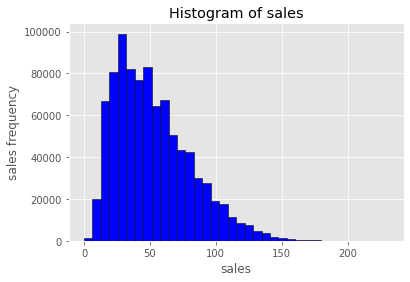

In [ ]:
#sales distribution

plt.hist(df_plots['sales'], color = 'blue', edgecolor = 'black', bins = int(180/5))


plt.title('Histogram of sales')
plt.xlabel('sales')
plt.ylabel('sales frequency')

print('Skew Dist:',df_plots['sales'].skew())

#right skewed

#### Observations


*   Here the sales distibution seems to be right skewed



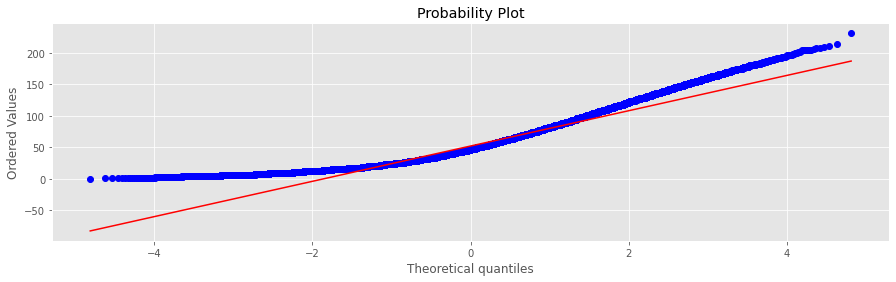

In [ ]:
# Checking the Distribution of the Sales Feature
import scipy.stats as stat
import pylab 

def plot_data(df_plots,feature):
  plt.figure(figsize=(15,4))
  plt.subplot(1,1,1)
  stat.probplot(df_plots[feature],dist='norm',plot=pylab)
  plt.show()

plot_data(df_plots,'sales')

#### Observations


*   Even though the sales distribution is right skewed there is a upward trend in the sales each year



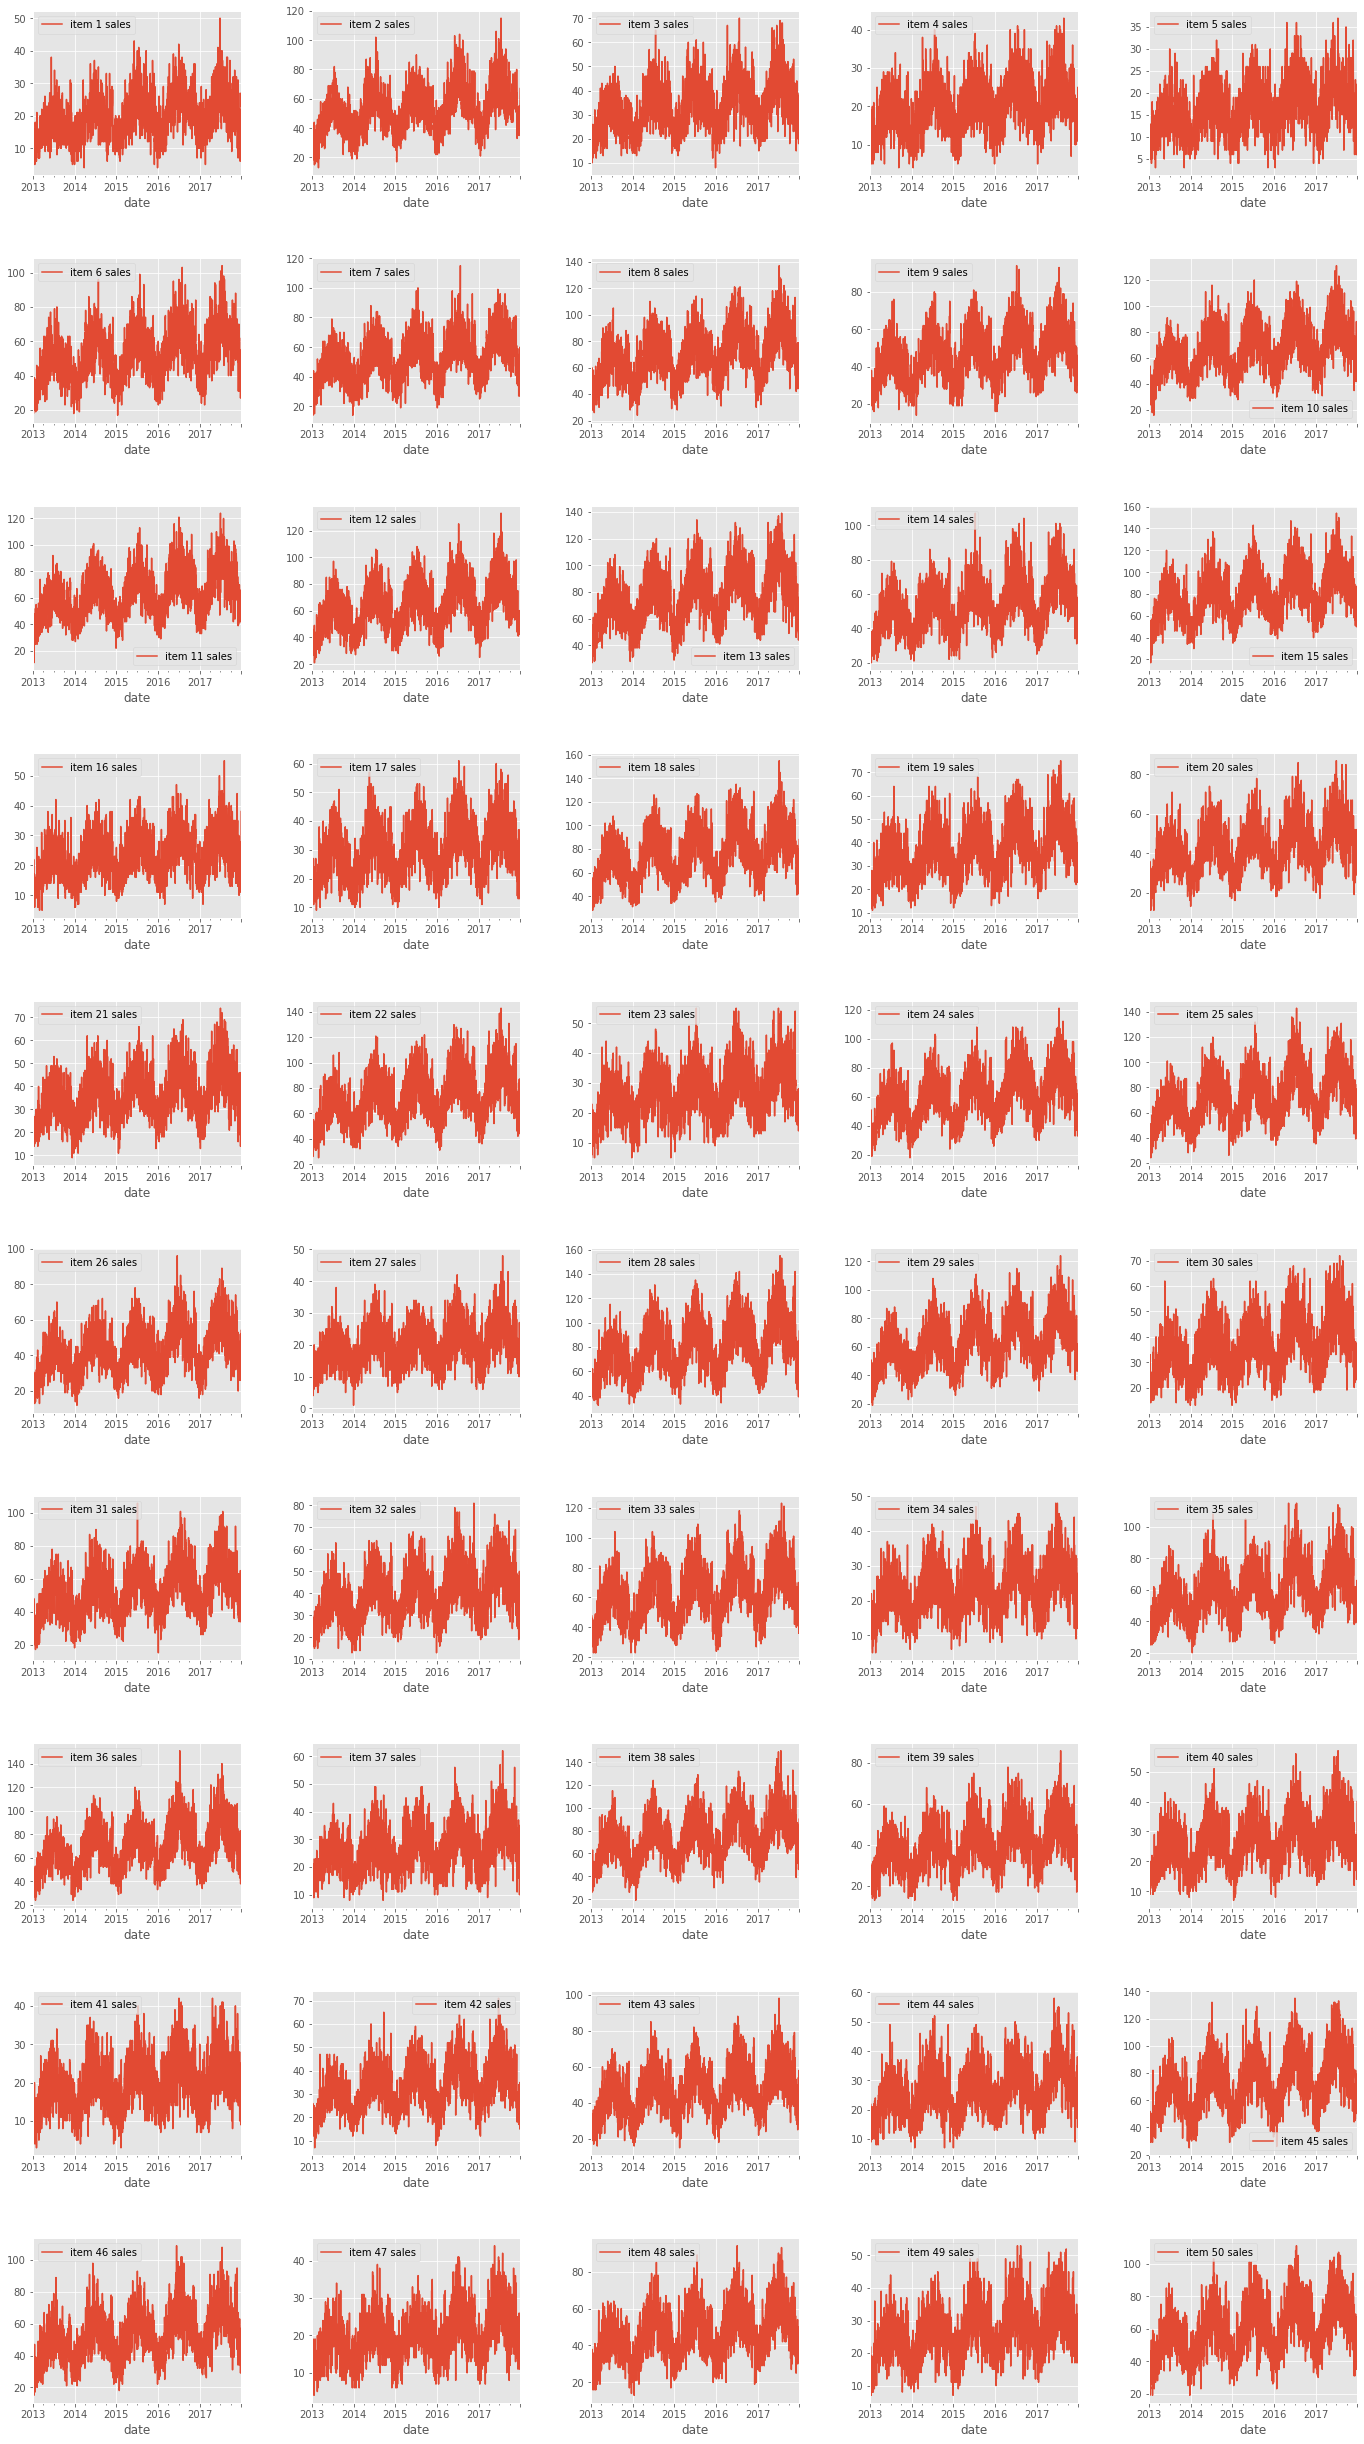

In [ ]:
#item average sales over years

store= 1

sub = df_plots[df_plots.store == store].set_index("date")

fig, axis = plt.subplots(10,5, figsize =(20,35))
for i in range(1,51):
  if i < 6:
    sub[sub.item == i].sales.plot(ax = axis[0, i -1], legend = True, label = "item " + str(i)+" sales")
  if i >= 6 and i < 11:
    sub[sub.item == i].sales.plot(ax = axis[1, i -6], legend = True, label = "item " + str(i)+" sales")
  if i >=11 and i < 16:
    sub[sub.item == i].sales.plot(ax = axis[2, i -11], legend = True , label = "item " + str(i)+ " sales")
  if i >=16 and i < 21:
    sub[sub.item == i].sales.plot(ax = axis[3, i -16], legend = True , label = "item " +str(i)+ " sales")
  if i >= 21 and i < 26:
    sub[sub.item == i].sales.plot(ax = axis[4, i -21], legend = True, label = "item " + str(i)+ " sales")
  if i >= 26 and i < 31:
    sub[sub.item == i].sales.plot(ax = axis[5, i -26], legend = True , label = "item " +str(i)+ " sales")
  if i >= 31 and i < 36:
    sub[sub.item == i].sales.plot(ax = axis[6, i -31], legend = True, label = "item " +str(i)+ " sales")
  if i >= 36 and i < 41:
    sub[sub.item == i].sales.plot(ax = axis[7, i -36], legend = True, label = "item " +str(i)+ " sales")
  if i >= 41 and i < 46: 
    sub[sub.item == i].sales.plot(ax = axis[8, i -41], legend = True, label = "item " +str(i)+ " sales")
  if i >= 46 and i <= 50:
    sub[sub.item == i].sales.plot(ax = axis[9, i -46], legend = True, label ="item " +str(i)+ " sales")

plt.tight_layout(pad=4.5)

#### Observations


*   Each item has a seasonal and upward trend each year



In [ ]:
df_plots['year']=df_plots['date'].dt.year
df_plots['month']=df_plots['date'].dt.month
df_plots['quarter']=df_plots['date'].dt.quarter
df_plots.head()

date  store  item  sales  year  month  quarter
0      2013-01-01      1     1     13  2013      1        1
211816 2013-01-01      7    12     26  2013      1        1
832656 2013-01-01      7    46     27  2013      1        1
213642 2013-01-01      8    12     54  2013      1        1
215468 2013-01-01      9    12     35  2013      1        1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


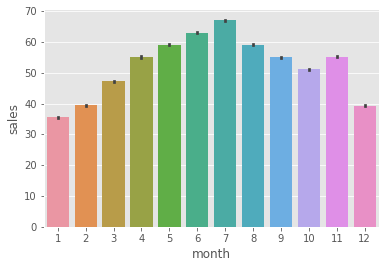

In [ ]:
sns.barplot(df_plots['month'],df_plots['sales'])

#### Observations


*   Here we can see that there is a high sales in the middle of the year 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


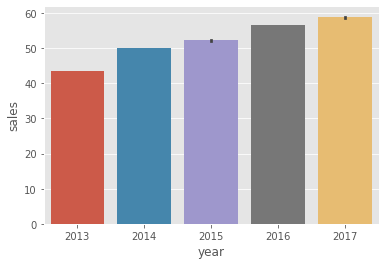

In [ ]:
sns.barplot(df_plots['year'],df_plots['sales'])

#### Observations

*   Here we can see that there is a trend over the sales each year.



[Text(0.5, 1.0, 'Monthly sales')]

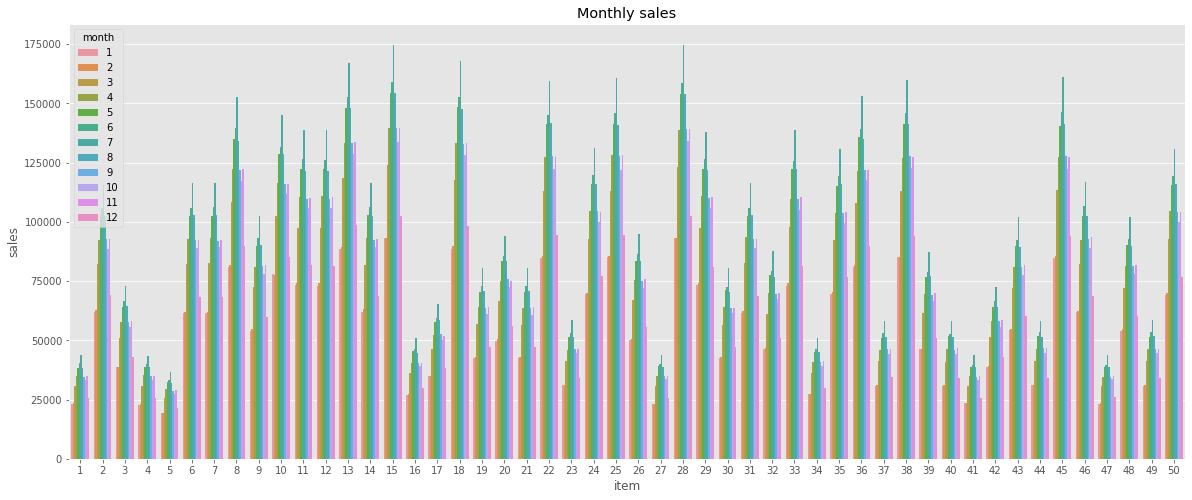

In [ ]:
month_item = df_plots.groupby(['month','item']).agg({  "sales"   : "sum"}).reset_index()

# ploting the quarterly wise each item sales 
plt.figure(figsize=(20, 8))
sns.barplot(data = month_item,x = 'item' ,y = 'sales', hue = 'month').set(title='Monthly sales')

[Text(0.5, 1.0, 'Quarterly sales')]

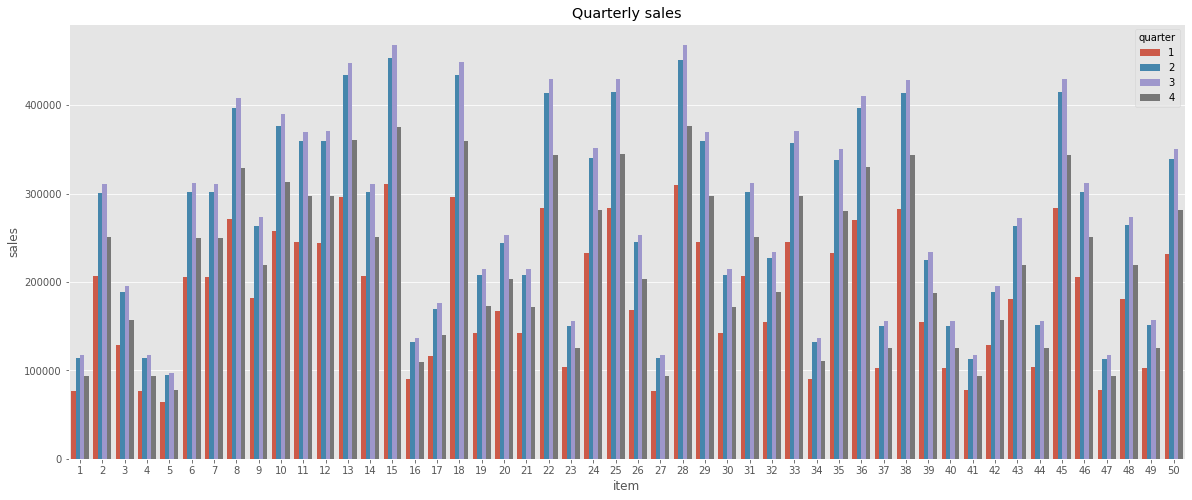

In [ ]:
quarter_item = df_plots.groupby(['quarter','item']).agg({  "sales"   : "sum"}).reset_index()

# ploting the quarterly wise each item sales 
plt.figure(figsize=(20, 8))
sns.barplot(data = quarter_item,x = 'item' ,y = 'sales', hue = 'quarter').set(title='Quarterly sales')

In [ ]:
#stores sales 2013 - 2017

store_sales_month_sum = {}
store_sales_month_plot = {}

for store in range(1, 11):
  store_sales_month_sum[store] = []
  store_sales_month_plot[store] = []
  for year in range(2013,2018):
    for month in range(1,13):
      store_sales_month = df_plots[(df_plots["month"] == month) & (df_plots["year"] == year)]
      store_sales_month_sum[store].append(store_sales_month["sales"].sum())
      store_sales_month_plot[store].append(str(year)+"-"+str(month))

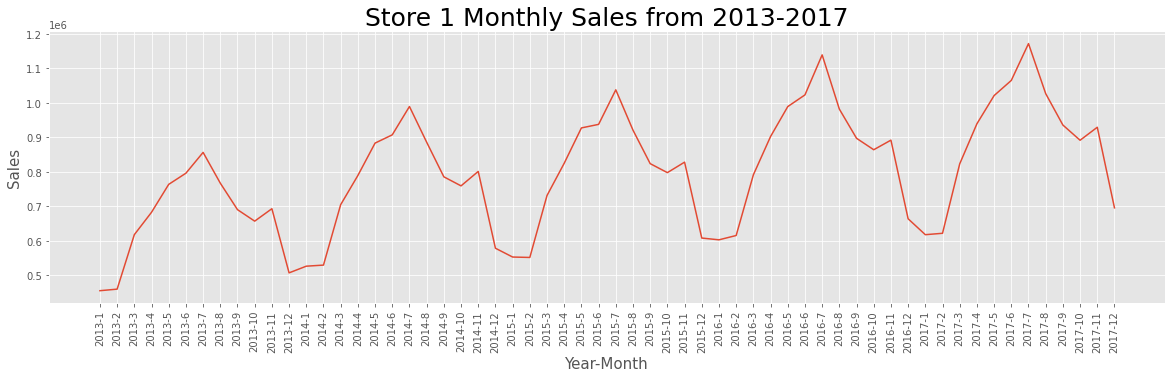

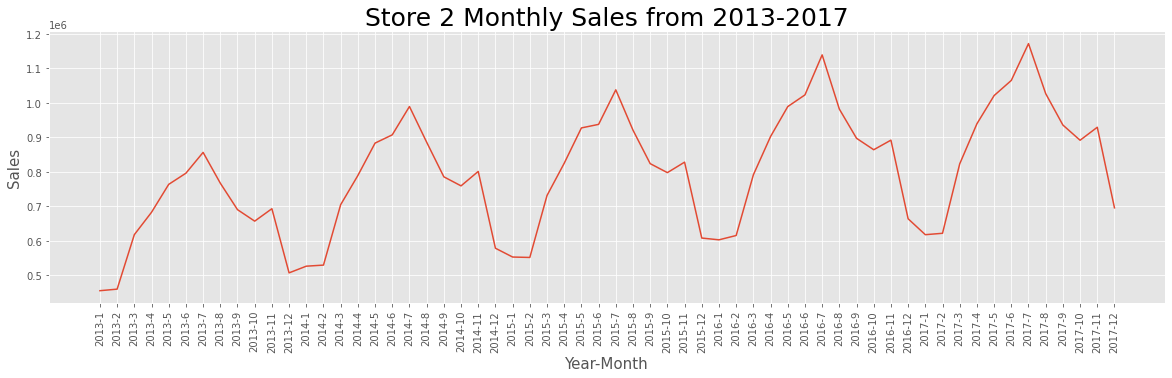

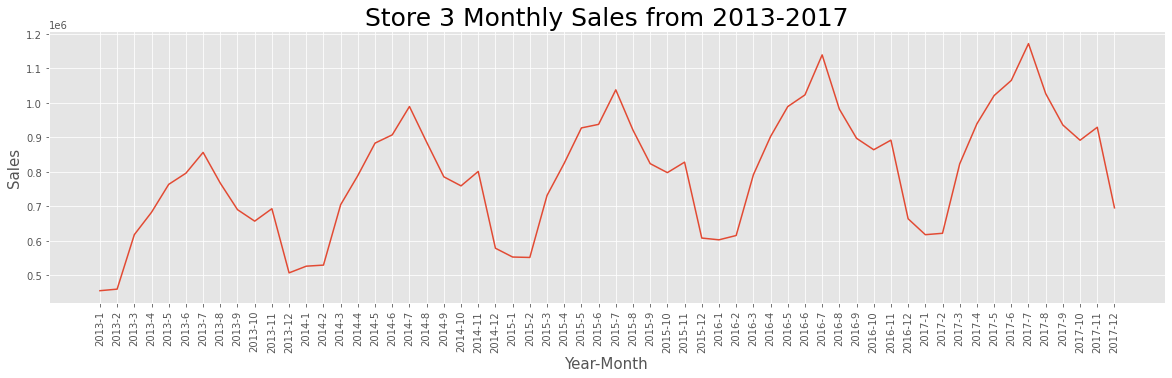

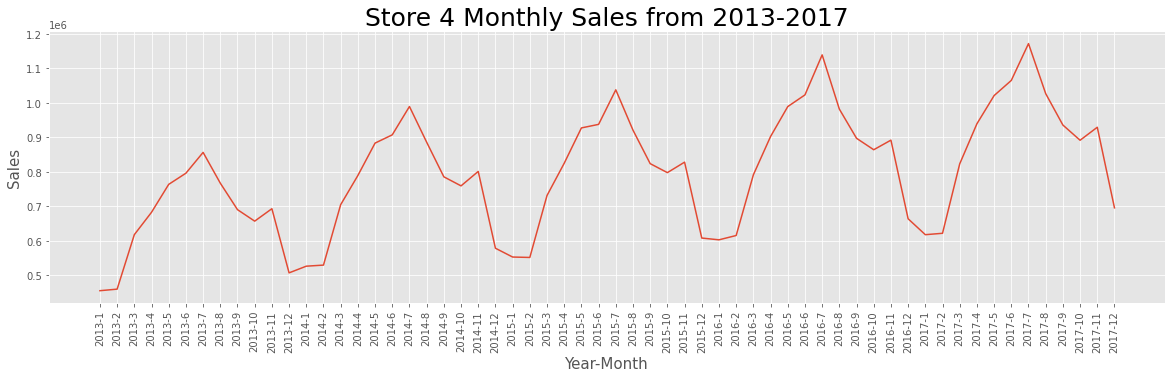

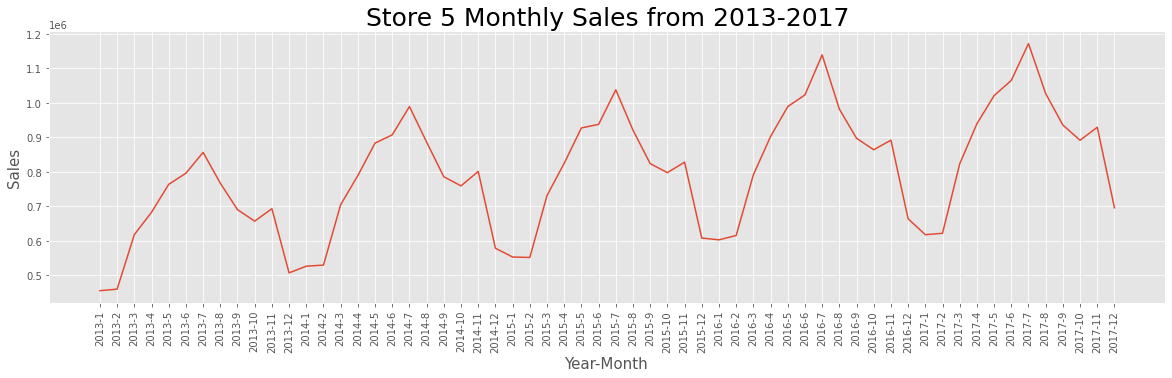

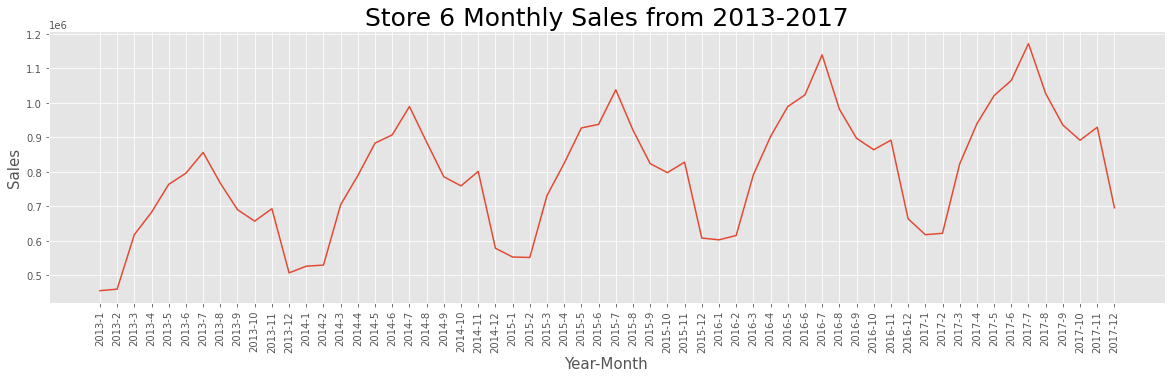

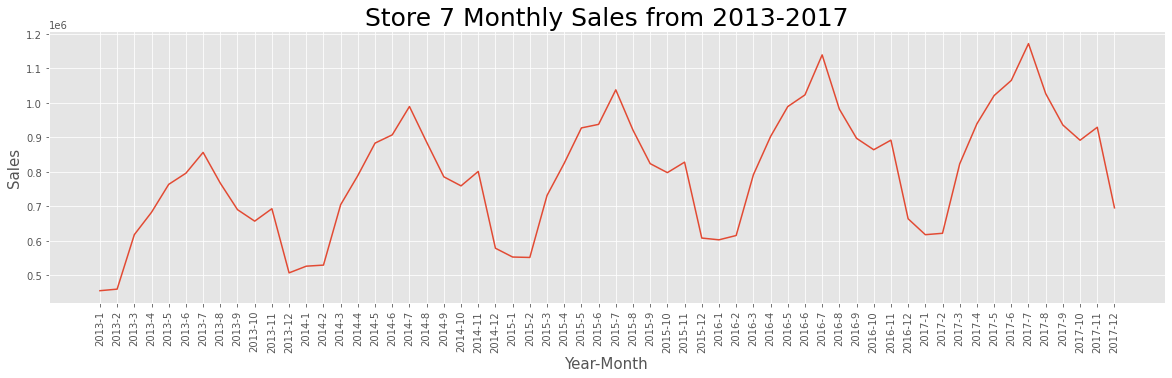

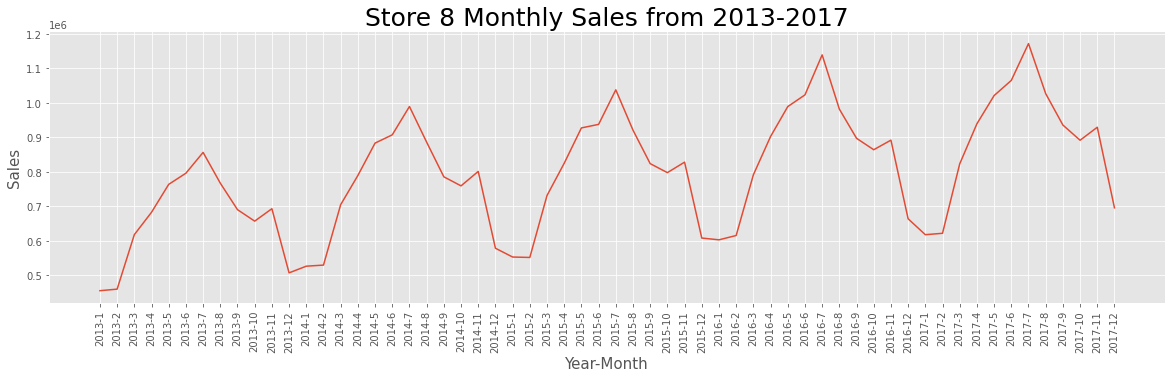

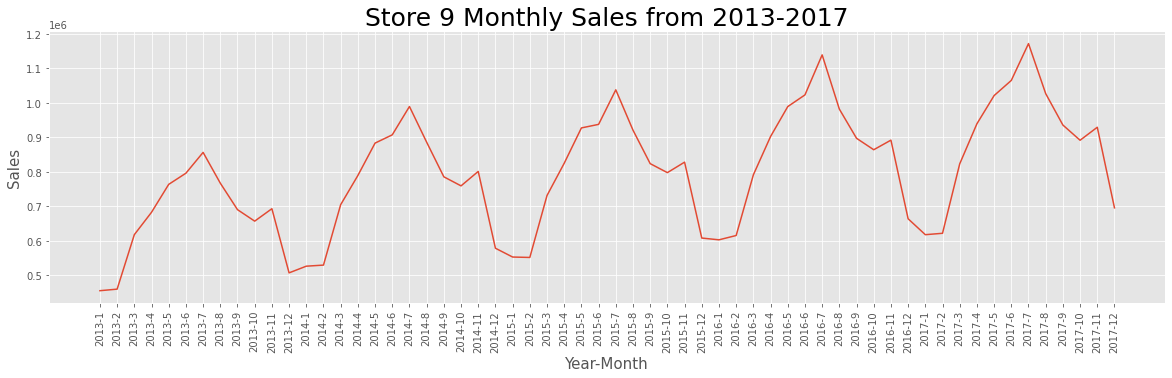

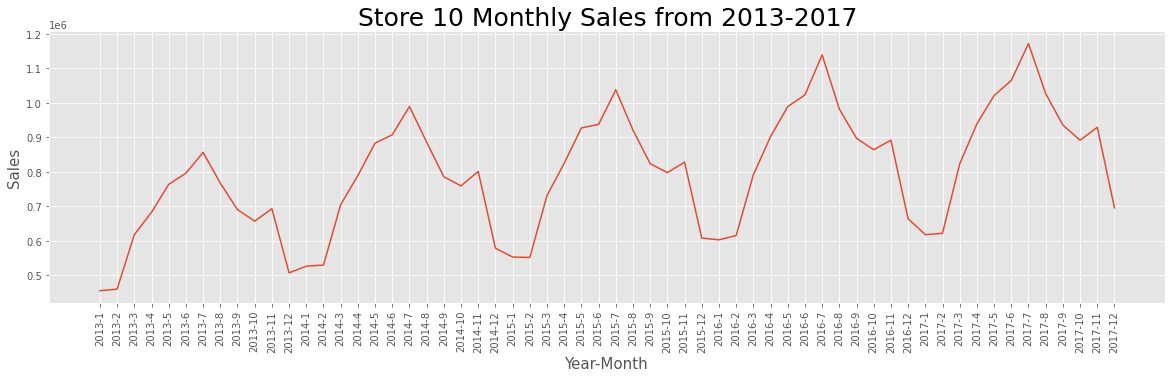

In [ ]:
for store in range(1,11) :
  plt.figure(figsize=(20,5))
  plt.plot(store_sales_month_plot[store], store_sales_month_sum[store])
  plt.xlabel("Year-Month",fontsize=15)
  plt.ylabel("Sales",fontsize=15)
  plt.title('Store '+str(store)+' Monthly Sales from 2013-2017', fontsize=25)
  plt.xticks(rotation=90)
  plt.show()

#### Observations

*   Here we can see that each store has a same kind of seasonality pattern each year



In [ ]:
store_item_df = pd.pivot_table(df_plots, index = "item", values ="sales", columns ="store", margins= True, aggfunc= np.mean)
store_item_df.head()

store          1          2          3          4          5          6  \
item                                                                      
1      19.971522  28.173604  25.070099  22.938664  16.739321  16.717963   
2      53.148959  75.316539  66.804491  61.715225  44.488499  44.533954   
3      33.208105  46.992333  41.771084  38.548193  27.835706  27.811062   
4      19.956188  28.234940  25.116101  23.086528  16.776561  16.754107   
5      16.612815  23.540526  20.857612  19.525192  14.086528  13.893209   

store          7          8          9         10        All  
item                                                          
1      15.159365  26.983571  23.325849  24.736035  21.981599  
2      40.717963  71.656627  61.792442  65.566813  58.574151  
3      25.531216  45.076123  38.535049  41.113363  36.642223  
4      15.358160  26.948521  23.150055  24.721249  22.010241  
5      12.733844  22.427711  19.272180  20.637459  18.358708

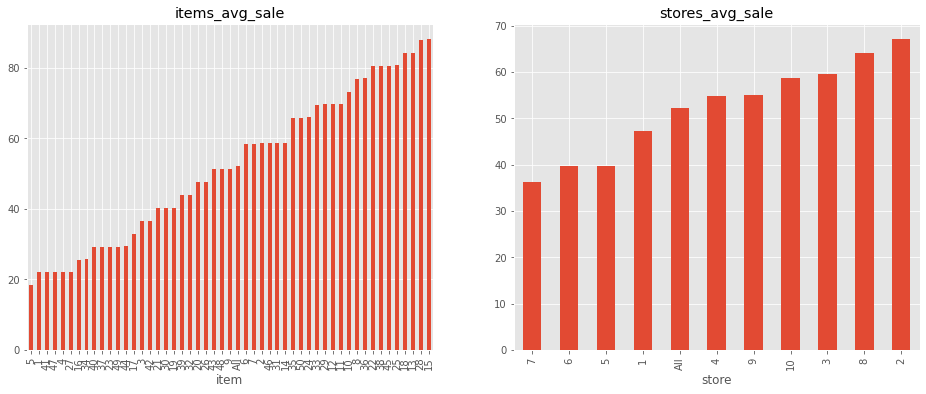

In [ ]:
#sorted Item avg sale and store avg sale using mean

fig,(ax1, ax2) = plt.subplots(1,2, figsize = (16,6))
store_item_df["All"].sort_values().plot.bar(ax = ax1, title = "items_avg_sale")

store_item_df.loc['All',:].sort_values().plot.bar(ax = ax2, title = "stores_avg_sale")

#### Observations


*   We can see that there are particular items which are getting higher sales
*   Item no 5 seems to be the least sold item and item no 28 and 15 seems to be highly sold items
*   And also we can see that the store no 7 has the least sales and store no 2 has the higher sales



In [ ]:
i = store_item_df["All"].sort_values().index
g = store_item_df.loc["All",:].sort_values().index
store_item_df = store_item_df[g]
store_item_df = store_item_df.reindex(i)

store_item_df.drop("All", axis = 1, inplace = True)
store_item_df.drop("All", axis = 0, inplace = True)

store_item_df.head()

store          7          6          5          1          4          9  \
item                                                                      
5      12.733844  13.893209  14.086528  16.612815  19.525192  19.272180   
1      15.159365  16.717963  16.739321  19.971522  22.938664  23.325849   
41     15.471522  16.607338  16.830778  20.002738  23.168127  23.191128   
47     15.479189  16.708653  16.699343  19.814348  23.114458  23.003286   
4      15.358160  16.754107  16.776561  19.956188  23.086528  23.150055   

store         10          3          8          2  
item                                               
5      20.637459  20.857612  22.427711  23.540526  
1      24.736035  25.070099  26.983571  28.173604  
41     24.654984  24.989047  27.036145  28.069551  
47     24.755750  25.120482  27.150055  28.187842  
4      24.721249  25.116101  26.948521  28.234940

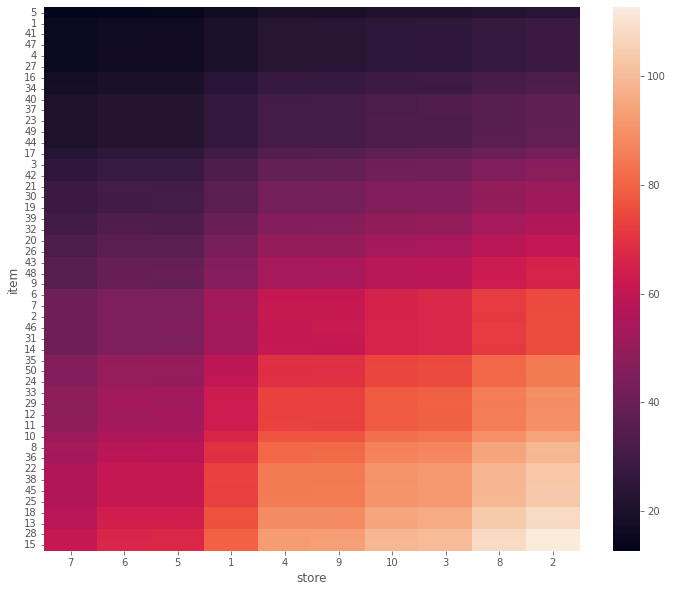

In [ ]:
#heatmap for items over higher to lower prices

plt.figure(figsize= (12,10))
sns.heatmap(store_item_df)

#### Observations

*   The higher no of sales seemsto be in the store no 2 and the higher selling item seems to be item no 15
*   And the least sales seems to be in the store 7 and the least selling items seems to the item no 5



### Feature Engineering

In [ ]:
#aggreating the data in item level

df1 = df.copy()
df1 = df1.groupby(['item','date'])['sales'].sum().reset_index()
df1.head()

item       date  sales
0     1 2013-01-01    133
1     1 2013-01-02     99
2     1 2013-01-03    127
3     1 2013-01-04    145
4     1 2013-01-05    149

In [ ]:
#aggreated the data for 90 days period from 2013 - 2017

def func(item_df):
  temp_df = item_df["date"]
  item_df["sales"] = item_df["sales"].rolling(window=90,min_periods=7).sum().shift(-89)  
  item_df["date"] = temp_df
  return item_df

df1 = df1.groupby(["item"]).apply(lambda item_df : func(item_df))

In [ ]:
def create_date_feature(df):
  df1["day_of_week"] = df.date.dt.dayofweek
  df1["day_of_month"] = df.date.dt.days_in_month
  df1["day_of_year"] = df.date.dt.dayofyear
  df1["month"] = df.date.dt.month
  df1["year"] = df.date.dt.year
  df1["is_weekend"] = df.date.dt.weekday // 4 #also included Friday as weekend
  df1["is_month_start"] = df.date.dt.is_month_start.astype(int)
  df1["is_month_end"] = df.date.dt.is_month_end.astype(int)
  df1["quarter"] = df.date.dt.quarter
  return df1

df1 = create_date_feature(df).dropna()
df1

item       date    sales  day_of_week  day_of_month  day_of_year  \
0         1 2013-01-01  12847.0            1            31            1   
1         1 2013-01-02  12848.0            2            31            2   
2         1 2013-01-03  12936.0            3            31            3   
3         1 2013-01-04  13019.0            4            31            4   
4         1 2013-01-05  13103.0            5            31            5   
...     ...        ...      ...          ...           ...          ...   
91206    50 2017-09-29  62200.0            4            30          272   
91207    50 2017-09-30  61962.0            5            30          273   
91208    50 2017-10-01  61687.0            6            31          274   
91209    50 2017-10-02  61392.0            0            31          275   
91210    50 2017-10-03  61395.0            1            31          276   

       month  year  is_weekend  is_month_start  is_month_end  quarter  
0          1  2013           0               1             0        1  
1          1  2013           0               0             0        1  
2          1  2013           0               0             0        1  
3          1  2013           1               0             0        1  
4          1  2013           1               0             0        1  
...      ...   ...         ...             ...           ...      ...  
91206      9  2017           1               0             0        3  
91207      9  2017           1               0             1        3  
91208     10  2017           1               1             0        4  
91209     10  2017           0               0             0        4  
91210     10  2017           0               0             0        4  

[86850 rows x 12 columns]

#### Observations


*   Here we added some extra features to get more accuracy in the model
*   And where we are doing 90 days period aggregation it leads to NaN values so we dropped the the Nan Values and ended up getting the last date as 03/10/2017



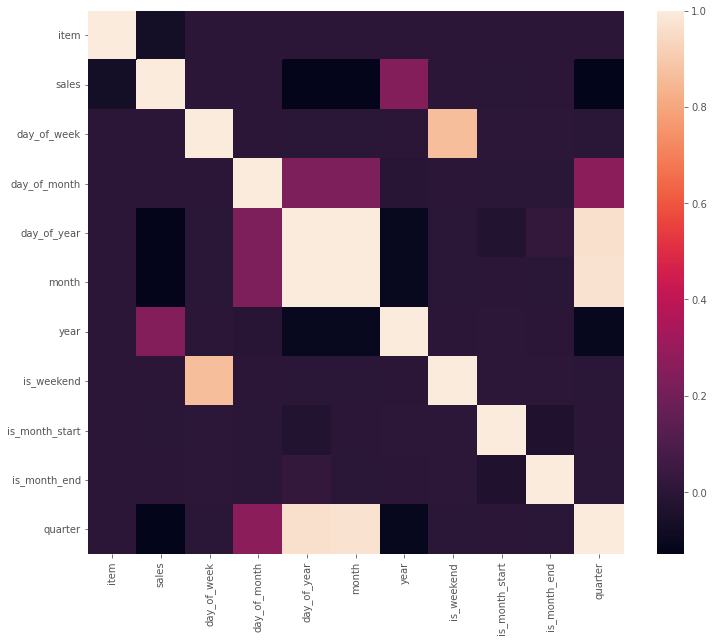

In [ ]:
plt.figure(figsize =( 12,10))
sns.heatmap(df1.corr())

#### Observations



*   Here we are checking the correaltion of the features and we can see that month and quater, day_of_year and quarter, month and day_of_year are highly correlated 
*   There is no need of removing the highly correlated features because we are dealing with the time series data





In [ ]:
df2 = df1.copy()
df2 = df2.set_index("date", drop = True)
df2

item    sales  day_of_week  day_of_month  day_of_year  month  \
date                                                                       
2013-01-01     1  12847.0            1            31            1      1   
2013-01-02     1  12848.0            2            31            2      1   
2013-01-03     1  12936.0            3            31            3      1   
2013-01-04     1  13019.0            4            31            4      1   
2013-01-05     1  13103.0            5            31            5      1   
...          ...      ...          ...           ...          ...    ...   
2017-09-29    50  62200.0            4            30          272      9   
2017-09-30    50  61962.0            5            30          273      9   
2017-10-01    50  61687.0            6            31          274     10   
2017-10-02    50  61392.0            0            31          275     10   
2017-10-03    50  61395.0            1            31          276     10   

            year  is_weekend  is_month_start  is_month_end  quarter  
date                                                                 
2013-01-01  2013           0               1             0        1  
2013-01-02  2013           0               0             0        1  
2013-01-03  2013           0               0             0        1  
2013-01-04  2013           1               0             0        1  
2013-01-05  2013           1               0             0        1  
...          ...         ...             ...           ...      ...  
2017-09-29  2017           1               0             0        3  
2017-09-30  2017           1               0             1        3  
2017-10-01  2017           1               1             0        4  
2017-10-02  2017           0               0             0        4  
2017-10-03  2017           0               0             0        4  

[86850 rows x 11 columns]

In [ ]:
df2 = df2.dropna()

In [ ]:
df2.isnull().sum()

item              0
sales             0
day_of_week       0
day_of_month      0
day_of_year       0
month             0
year              0
is_weekend        0
is_month_start    0
is_month_end      0
quarter           0
dtype: int64

In [ ]:
df2.columns

Index(['item', 'sales', 'day_of_week', 'day_of_month', 'day_of_year', 'month',
       'year', 'is_weekend', 'is_month_start', 'is_month_end', 'quarter'],
      dtype='object')

## Modelling

### Model 1

*   ### XGBOOST



In [ ]:
# dictionary for test data forecast results
test_forecast_dict_xgb = dict()


for i in list(df2['item'].unique()):

  # filtering the data item-wise
  data = df2[df2['item']==i].drop(['item'], axis=1)
  #print(data)
  
  # Splitting the dataset into dependent and independent variable
  x = data.drop(['sales'], axis=1)
  y = data['sales']
   
  # Splitting data into training and testing sets
  # Here, we are limiting the test data upto 03/10/2017 because item no 50 is missing 90 days of data as a result of
  # rolling(90), shift(-89) and dropna() Hence, extending the prediction upto 31/12/2017 is resulting in a Value Error.
  
  x_train_xgb = x.loc[:'2016-12-31']
  x_test_xgb = x.loc['2017-01-01':'2017-10-03'] 
  y_train_xgb = y.loc[:'2016-12-31']
  y_test_xgb = y.loc['2017-01-01':'2017-10-03']

  s_scaler = StandardScaler()
  x_train_xgb = s_scaler.fit_transform(x_train_xgb)
  x_test_xgb = s_scaler.transform(x_test_xgb)
  

  # Initializing the model
  xgbr = XGB(verbosity=0)
  
  # Fitting the model
  xgbr.fit(x_train_xgb, y_train_xgb)


  # predicting the test data
  y_pred_xgb = xgbr.predict(x_test_xgb)
  
  # creating key and value for test_forecast dictionary
  k = 'Item_'+str(i)
  v = y_pred_xgb

  # dictionary for test data
  test_forecast_dict_xgb.update({k:v})

In [ ]:
xgb= pd.DataFrame({ "Predicted": y_pred_xgb,"Actual": y_test_xgb})
xgb = np.round(xgb)
xgb

Predicted   Actual
date                          
2017-01-01    50250.0  51966.0
2017-01-02    50345.0  52224.0
2017-01-03    50564.0  52736.0
2017-01-04    50701.0  52919.0
2017-01-05    50955.0  53158.0
...               ...      ...
2017-09-29    60627.0  62200.0
2017-09-30    60466.0  61962.0
2017-10-01    59242.0  61687.0
2017-10-02    59171.0  61392.0
2017-10-03    59255.0  61395.0

[276 rows x 2 columns]

In [ ]:
# Evaluation Metrics xgb

r2_xgb = metrics.r2_score(y_test_xgb, y_pred_xgb)
mse_xgb = metrics.mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test_xgb, y_pred_xgb))
mae_xgb = metrics.mean_absolute_error(y_test_xgb, y_pred_xgb)
mape_xgb = metrics.mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)

In [ ]:
# Dataframe for test data forecast
test_forecast_dict_xgb_df = pd.DataFrame(test_forecast_dict_xgb, index=[pd.date_range(start='2017-01-01', end='2017-10-03')])

# function for rounding off
def rounding_xgb(x):
  a = round(x,2)
  return a

for i in test_forecast_dict_xgb_df.columns:
  test_forecast_dict_xgb_df[i] = test_forecast_dict_xgb_df[i].apply(lambda x:rounding_xgb(x))

test_forecast_dict_xgb_df = test_forecast_dict_xgb_df.reset_index()
test_forecast_dict_xgb_df

level_0    Item_1    Item_2    Item_3    Item_4    Item_5    Item_6  \
0   2017-01-01  16663.74  45064.78  27920.15  16864.50  14015.82  44681.24   
1   2017-01-02  16665.22  45046.55  27924.95  16887.04  14019.39  44702.26   
2   2017-01-03  16733.08  45195.92  28086.79  16980.64  14088.52  44882.59   
3   2017-01-04  16784.09  45285.04  28127.23  17045.57  14147.58  45015.63   
4   2017-01-05  16934.67  45702.68  28301.03  17211.72  14274.62  45422.15   
..         ...       ...       ...       ...       ...       ...       ...   
271 2017-09-29  20126.84  54101.52  33513.41  20109.37  16938.33  54050.03   
272 2017-09-30  20044.51  53972.25  33381.49  20034.89  16893.20  53828.93   
273 2017-10-01  19688.87  53004.73  32818.96  19774.79  16563.63  52837.16   
274 2017-10-02  19673.33  52937.94  32818.98  19731.78  16530.72  52832.43   
275 2017-10-03  19680.13  52987.61  32878.75  19768.37  16548.05  52874.29   

       Item_7    Item_8    Item_9  ...   Item_41   Item_42   Item_43  \
0    44324.05  58400.27  38961.30  ...  16893.74  28023.03  39372.02   
1    44324.14  58456.16  39062.34  ...  16929.24  28072.01  39450.52   
2    44671.34  58688.98  39173.66  ...  16957.96  28217.18  39577.38   
3    44830.91  58899.74  39236.61  ...  17071.52  28305.07  39632.00   
4    45280.23  59383.09  39601.46  ...  17246.55  28559.73  39949.46   
..        ...       ...       ...  ...       ...       ...       ...   
271  53635.22  71023.56  47398.43  ...  20131.21  33623.41  47307.31   
272  53521.99  70793.81  47285.26  ...  20106.27  33583.03  47224.08   
273  52438.12  69439.76  46282.39  ...  19692.44  33092.02  46298.30   
274  52324.70  69218.41  46221.70  ...  19676.55  33065.93  46237.16   
275  52401.72  69341.97  46281.51  ...  19691.95  33102.02  46313.03   

      Item_44   Item_45   Item_46   Item_47   Item_48   Item_49   Item_50  
0    22451.95  61115.59  45080.28  16694.66  38870.10  22109.31  50249.85  
1    22430.85  61160.73  45109.75  16680.58  38863.93  22198.17  50345.18  
2    22547.32  61416.66  45307.62  16758.45  38980.85  22287.91  50564.27  
3    22630.72  61591.39  45451.11  16829.72  39092.08  22278.90  50700.63  
4    22840.59  62325.07  45879.90  17005.76  39513.09  22539.10  50955.30  
..        ...       ...       ...       ...       ...       ...       ...  
271  26790.87  74020.05  54047.92  20367.37  47450.05  26631.18  60626.80  
272  26736.88  73797.51  53829.28  20320.46  47402.84  26579.17  60466.37  
273  26149.79  72299.62  52866.93  19895.73  46177.41  26073.73  59242.35  
274  26091.20  72222.63  52664.61  19864.87  46103.75  26049.78  59171.05  
275  26142.82  72334.83  52735.36  19891.81  46184.62  26093.53  59255.23  

[276 rows x 51 columns]

In [ ]:
test_forecast_dict_xgb_df = test_forecast_dict_xgb_df.set_index('level_0', drop=True)
test_forecast_dict_xgb_df.index.name=None

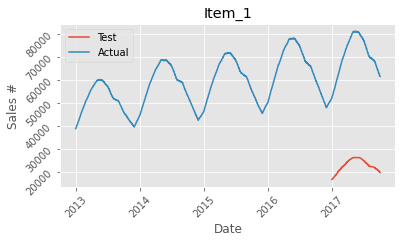

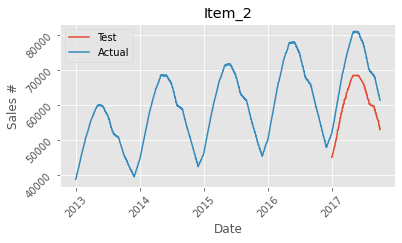

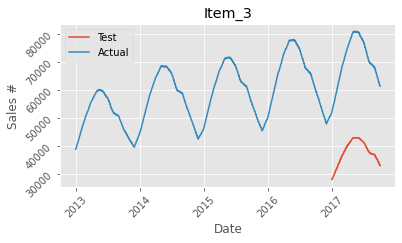

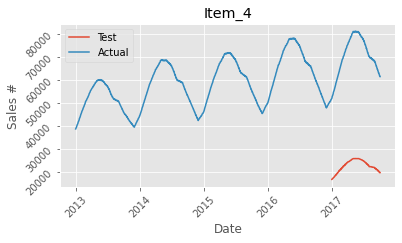

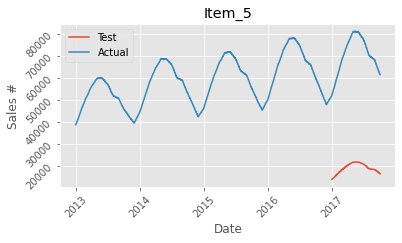

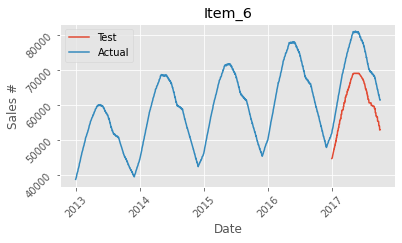

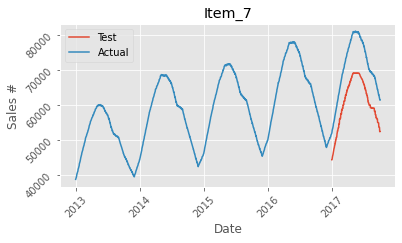

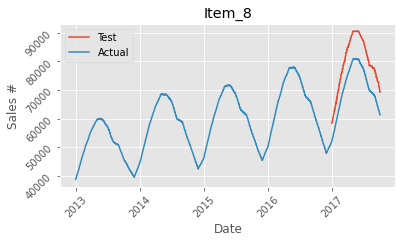

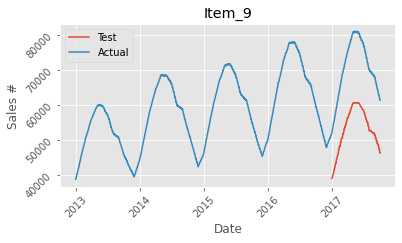

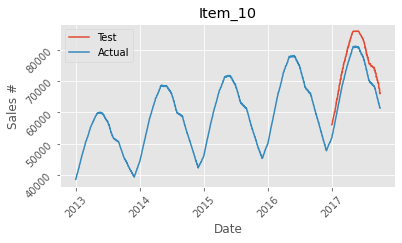

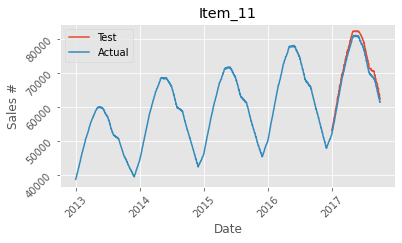

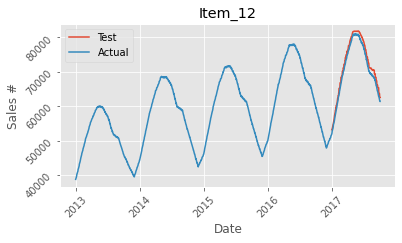

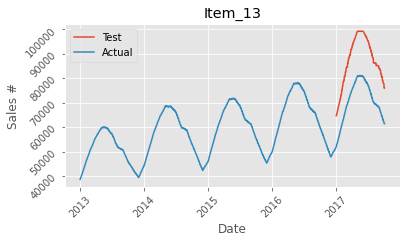

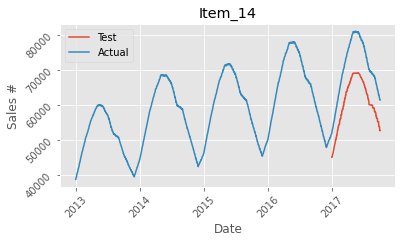

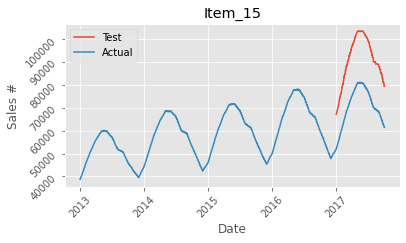

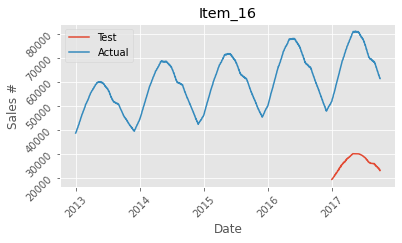

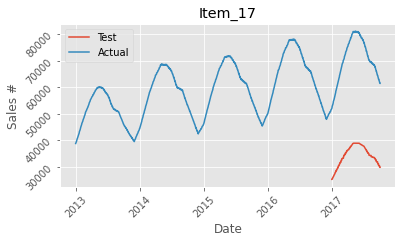

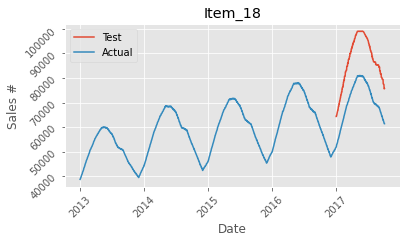

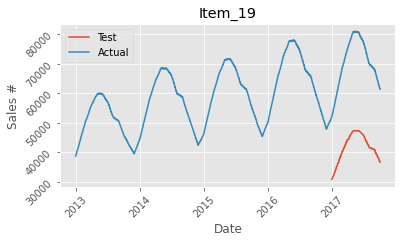

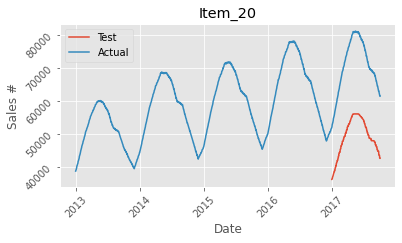

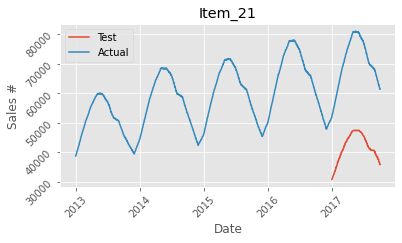

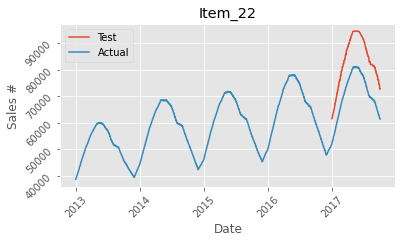

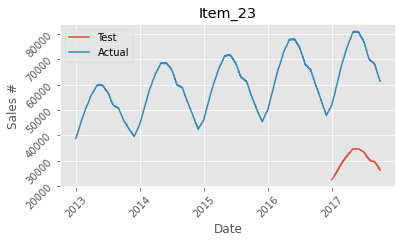

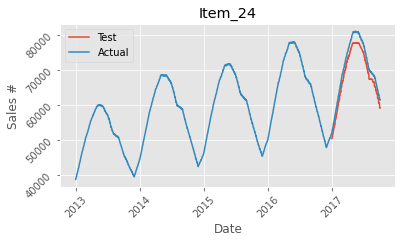

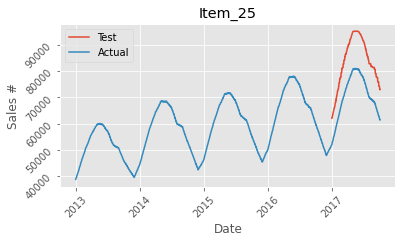

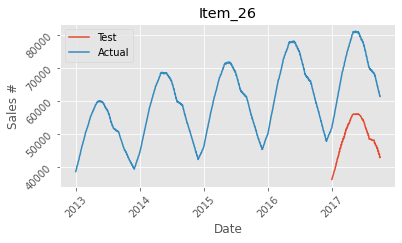

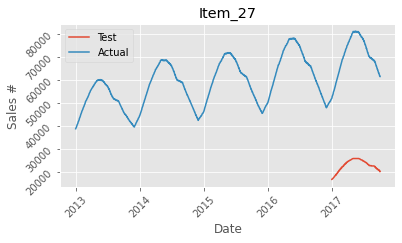

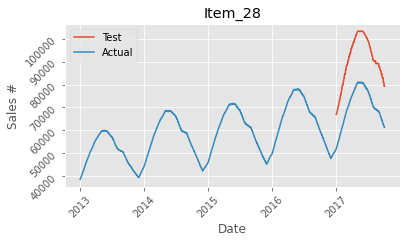

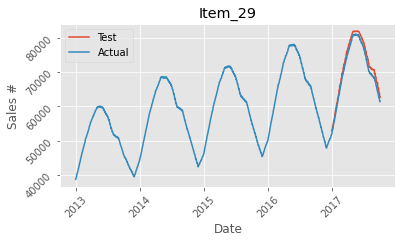

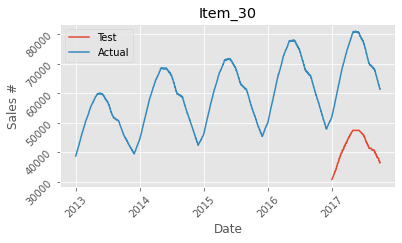

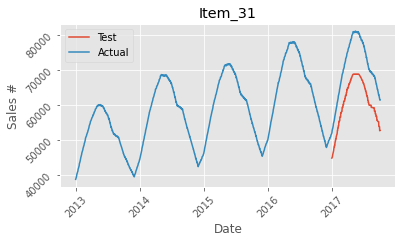

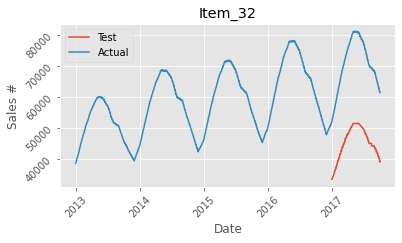

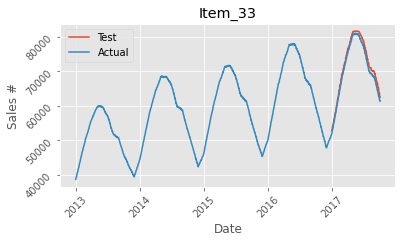

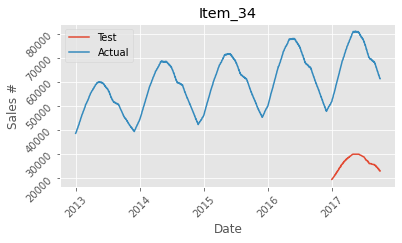

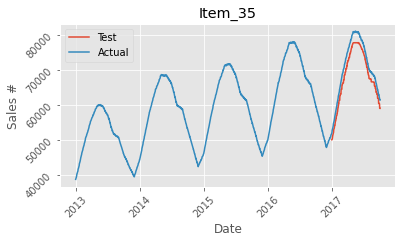

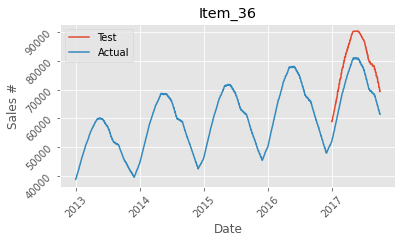

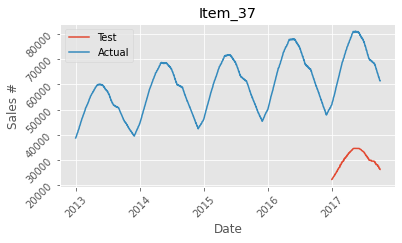

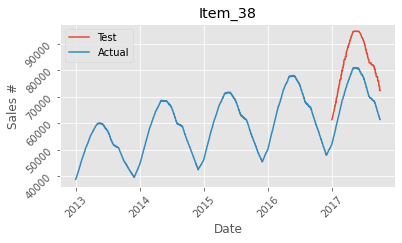

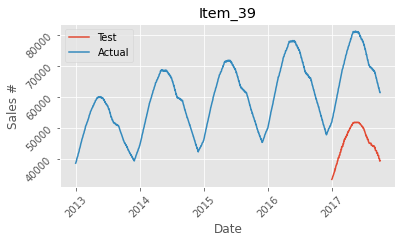

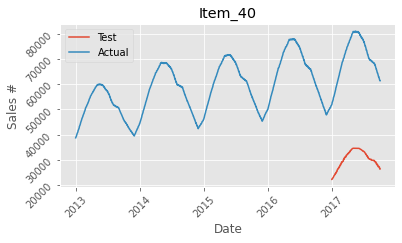

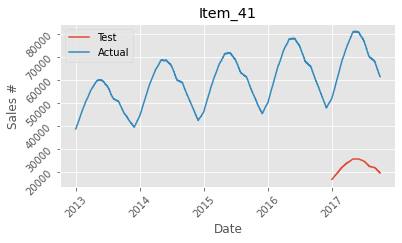

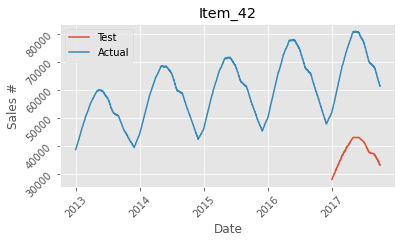

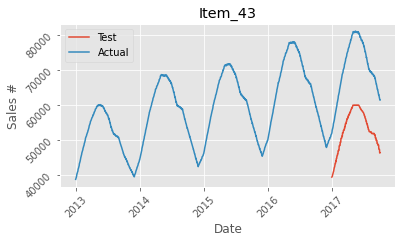

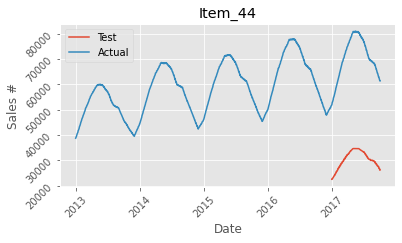

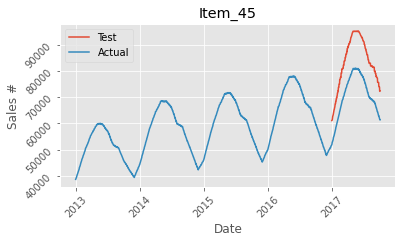

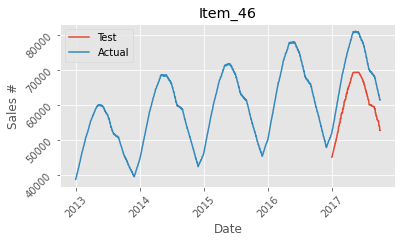

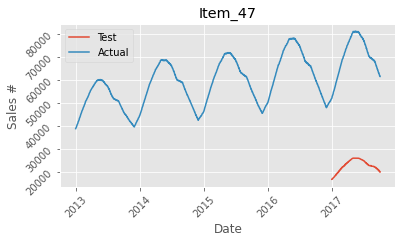

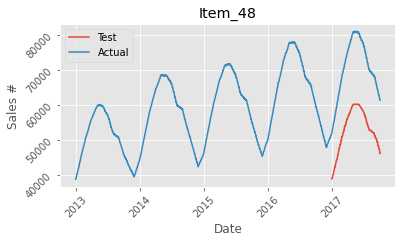

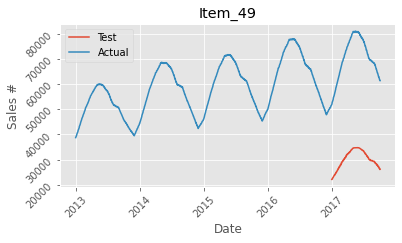

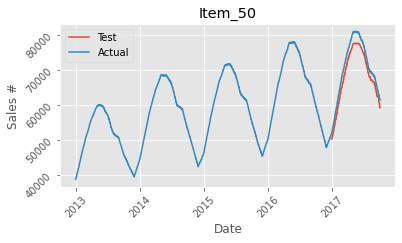

In [ ]:
# plotting forecast and actual sales

for k, v in test_forecast_dict_xgb.items():
  forecast = pd.DataFrame(v, index=pd.date_range(start='2017-01-01', end='2017-10-03'))
  plt.figure(figsize=(6,3))
  plt.title(k)
  plt.plot(forecast, label='Test')
  plt.plot(data.sales, label='Actual')
  plt.xlabel('Date', size=12)
  plt.ylabel('Sales #', size=12)
  plt.xticks(rotation=45, size=10)
  plt.yticks(rotation=45, size=10)
  plt.legend(loc='best')
  plt.show()

In [ ]:
dfxgb = df_test.copy()

dfxgb = dfxgb.groupby(['item','date']).agg({'sales':'sum'}).reset_index().set_index('date', drop=True)
dfxgb = dfxgb.groupby(['item']).sales.rolling(90).sum().shift(-89).dropna().reset_index()
dfxgb = pd.pivot_table(data=dfxgb, columns ='item', values='sales', index='date', aggfunc='sum')
dfxgb.index.name=None
dfxgb.columns.name=None
dfxgb_column_names = ['Item_'+str(i) for i in dfxgb.columns]
dfxgb.columns = dfxgb_column_names
dfxgb

Item_1   Item_2   Item_3   Item_4   Item_5   Item_6   Item_7  \
2013-01-01  12847.0  34650.0  21420.0  12884.0  10630.0  34251.0  34349.0   
2013-01-02  12848.0  34724.0  21472.0  12940.0  10678.0  34380.0  34470.0   
2013-01-03  12936.0  34917.0  21580.0  13041.0  10756.0  34531.0  34674.0   
2013-01-04  13019.0  35113.0  21664.0  13109.0  10800.0  34688.0  34836.0   
2013-01-05  13103.0  35248.0  21783.0  13155.0  10857.0  34831.0  35030.0   
...             ...      ...      ...      ...      ...      ...      ...   
2017-09-29  20796.0  55526.0  35038.0  20892.0  17515.0  55393.0  55590.0   
2017-09-30  20704.0  55278.0  34913.0  20814.0  17453.0  55195.0  55398.0   
2017-10-01  20642.0  55020.0  34763.0  20693.0  17411.0  54955.0  55139.0   
2017-10-02  20578.0  54778.0  34648.0  20635.0  17349.0  54758.0  54985.0   
2017-10-03  20610.0  54886.0  34718.0  20647.0  17377.0  54789.0  55073.0   

             Item_8   Item_9  Item_10  ...  Item_41  Item_42  Item_43  \
2013-01-01  45188.0  30415.0  42829.0  ...  12902.0  21400.0  30150.0   
2013-01-02  45320.0  30547.0  42939.0  ...  12960.0  21459.0  30282.0   
2013-01-03  45549.0  30726.0  43159.0  ...  13001.0  21519.0  30442.0   
2013-01-04  45772.0  30882.0  43399.0  ...  13077.0  21619.0  30558.0   
2013-01-05  46030.0  31030.0  43555.0  ...  13140.0  21765.0  30682.0   
...             ...      ...      ...  ...      ...      ...      ...   
2017-09-29  73597.0  48320.0  69892.0  ...  20727.0  34743.0  49141.0   
2017-09-30  73266.0  48114.0  69588.0  ...  20635.0  34633.0  48915.0   
2017-10-01  72910.0  47936.0  69244.0  ...  20543.0  34439.0  48672.0   
2017-10-02  72669.0  47811.0  68947.0  ...  20445.0  34309.0  48472.0   
2017-10-03  72762.0  47920.0  69005.0  ...  20496.0  34371.0  48507.0   

            Item_44  Item_45  Item_46  Item_47  Item_48  Item_49  Item_50  
2013-01-01  17243.0  47070.0  34620.0  12965.0  30037.0  17099.0  38720.0  
2013-01-02  17293.0  47231.0  34700.0  13015.0  30109.0  17164.0  38874.0  
2013-01-03  17357.0  47482.0  34864.0  13072.0  30226.0  17254.0  39034.0  
2013-01-04  17429.0  47676.0  35004.0  13139.0  30348.0  17329.0  39200.0  
2013-01-05  17481.0  47943.0  35177.0  13183.0  30509.0  17400.0  39378.0  
...             ...      ...      ...      ...      ...      ...      ...  
2017-09-29  28082.0  76563.0  56121.0  20892.0  49122.0  27597.0  62200.0  
2017-09-30  27960.0  76174.0  55856.0  20796.0  48893.0  27502.0  61962.0  
2017-10-01  27833.0  75784.0  55614.0  20731.0  48699.0  27346.0  61687.0  
2017-10-02  27718.0  75504.0  55435.0  20648.0  48587.0  27262.0  61392.0  
2017-10-03  27762.0  75603.0  55565.0  20692.0  48651.0  27275.0  61395.0  

[1737 rows x 50 columns]

In [ ]:
# dfxgb - Actual sales (demand)
# test_forecast_dict_xgb_df - Forecast (supply)

# (Forecast - Actual) = (Supply - Demand) > 0 => Rs 10 else Rs 3

results_xgb = (test_forecast_dict_xgb_df - dfxgb).dropna()

# Actual sales = Demand
# Forecast sales = Supply
# When demand > supply = Oppurtunity loss - multiply by Rs 3
# When demand < supply = Retention loss - multiplt by Rs 10

def orloss(x):
  if x > 0:
    x = x*10
    return x
  else:
    x = x*3
    return x

for i in results_xgb.columns:
  results_xgb[i] = results_xgb[i].apply(lambda x: orloss(x))

results_xgb

Item_1   Item_2   Item_3   Item_4   Item_5   Item_6   Item_7  \
2017-01-01 -1845.78 -2283.66 -2951.55  -532.50 -1998.54 -4406.28 -4922.85   
2017-01-02 -2108.34 -3175.35 -3300.15  -722.88 -2188.83 -5018.22 -5699.58   
2017-01-03 -2357.76 -4200.24 -3681.63  -922.08 -2386.44 -5980.23 -5911.98   
2017-01-04 -2369.73 -4388.88 -4007.31  -907.29 -2368.26 -5971.11 -5841.27   
2017-01-05 -2130.99 -3984.96 -3827.91  -636.84 -2218.14 -5366.55 -5135.31   
...             ...      ...      ...      ...      ...      ...      ...   
2017-09-29 -2007.48 -4273.44 -4573.77 -2347.89 -1730.01 -4028.91 -5864.34   
2017-09-30 -1978.47 -3917.25 -4594.53 -2337.33 -1679.40 -4098.21 -5628.03   
2017-10-01 -2859.39 -6045.81 -5832.12 -2754.63 -2542.11 -6353.52 -8102.64   
2017-10-02 -2714.01 -5520.18 -5487.06 -2709.66 -2454.84 -5776.71 -7980.90   
2017-10-03 -2789.61 -5695.17 -5517.75 -2635.89 -2486.85 -5744.13 -8013.84   

              Item_8   Item_9  Item_10  ...  Item_41  Item_42  Item_43  \
2017-01-01  -6629.19 -6608.10 -6109.98  ... -1263.78 -2807.91 -3899.94   
2017-01-02  -7391.52 -7006.98 -6830.70  ... -1319.28 -3098.97 -4309.44   
2017-01-03  -8661.06 -7915.02 -8000.25  ... -1740.12 -3575.46 -5239.86   
2017-01-04  -8547.78 -8116.17 -8066.07  ... -1561.44 -3506.79 -5439.00   
2017-01-05  -8102.73 -7438.62 -7126.05  ... -1336.35 -3108.81 -4957.62   
...              ...      ...      ...  ...      ...      ...      ...   
2017-09-29  -7720.32 -2764.71 -6603.90  ... -1787.37 -3358.77 -5501.07   
2017-09-30  -7416.57 -2486.22 -6032.16  ... -1586.19 -3149.91 -5072.76   
2017-10-01 -10410.72 -4960.83 -9527.46  ... -2551.68 -4040.94 -7121.10   
2017-10-02 -10351.77 -4767.90 -8995.26  ... -2305.35 -3729.21 -6704.52   
2017-10-03 -10260.09 -4915.47 -8788.44  ... -2412.15 -3806.94 -6581.91   

            Item_44   Item_45  Item_46  Item_47  Item_48  Item_49  Item_50  
2017-01-01 -1605.15  -7840.23 -2651.16 -2011.02 -5480.70 -3752.07 -5148.45  
2017-01-02 -2061.45  -8448.81 -3261.75 -2404.26 -6168.21 -3794.49 -5636.46  
2017-01-03 -2381.04  -9700.02 -3964.14 -2755.65 -7098.45 -4281.27 -6515.19  
2017-01-04 -2250.84  -9802.83 -3935.67 -2646.84 -7175.76 -4539.30 -6655.11  
2017-01-05 -2110.23  -8504.79 -3150.30 -2373.72 -6683.73 -4115.70 -6608.10  
...             ...       ...      ...      ...      ...      ...      ...  
2017-09-29 -3873.39  -7628.85 -6219.24 -1573.89 -5015.85 -2897.46 -4719.60  
2017-09-30 -3669.36  -7129.47 -6080.16 -1426.62 -4470.48 -2768.49 -4486.89  
2017-10-01 -5049.63 -10453.14 -8241.21 -2505.81 -7564.77 -3816.81 -7333.95  
2017-10-02 -4880.40  -9844.11 -8311.17 -2349.39 -7449.75 -3636.66 -6662.85  
2017-10-03 -4857.54  -9804.51 -8488.92 -2400.57 -7399.14 -3544.41 -6419.31  

[276 rows x 50 columns]

### Model 2

*   ### Decision Tree



In [ ]:
# dictionary for test data forecast
test_forecast_dict_dt = dict()


for i in list(df2['item'].unique()):
 
  # filtering the data item-wise
  split_data_dt = df2[df2['item']==i].drop(['item'], axis=1)
  
  # Splitting the dataset into dependent and independent variable
  x_dt = split_data_dt.drop(['sales'], axis=1)
  y_dt = split_data_dt['sales']
 
  
  x_train_dt = x_dt.loc[:'2016-12-31']
  x_test_dt = x_dt.loc['2017-01-01':'2017-10-03'] 
  y_train_dt = y_dt.loc[:'2016-12-31']
  y_test_dt = y_dt.loc['2017-01-01':'2017-10-03']

  s_scaler = StandardScaler()
  x_train_dt = s_scaler.fit_transform(x_train_dt)
  x_test_dt = s_scaler.transform(x_test_dt)
  

  # Initializing the model
  dtr_model = DecisionTreeRegressor(max_depth=18)
  
  # Fitting the model
  dtr_model.fit(x_train_dt, y_train_dt)
  train_score_dt = dtr_model.score(x_train_dt, y_train_dt)
  cvs_train_dt = cross_val_score(dtr_model, x_train_dt, y_train_dt, cv=10)

  # predicting the test data
  y_pred_dt = dtr_model.predict(x_test_dt)



   # creating key and value for test_forecast dictionary
  k = 'Item_'+str(i)
  v = y_pred_dt 
  test_forecast_dict_dt.update({k:v})

In [ ]:
max_depth = dict()
for i in range(1,22):
  dtr_hpt = DecisionTreeRegressor(max_depth=i)
  hypt_model = dtr_hpt.fit(x_train_dt, y_train_dt)
  train_score = hypt_model.score(x_train_dt, y_train_dt)
  
  k = 'Depth_'+str(i)
  v = [train_score]
  max_depth.update({k:v})

max_depth = pd.DataFrame(max_depth)
max_depth = max_depth.transpose()
max_depth.index
max_depth.columns=['Train']
max_depth

Train
Depth_1   0.351533
Depth_2   0.578383
Depth_3   0.785837
Depth_4   0.873424
Depth_5   0.939212
Depth_6   0.975640
Depth_7   0.987860
Depth_8   0.994846
Depth_9   0.998160
Depth_10  0.999394
Depth_11  0.999817
Depth_12  0.999944
Depth_13  0.999978
Depth_14  0.999990
Depth_15  0.999994
Depth_16  0.999997
Depth_17  0.999999
Depth_18  0.999999
Depth_19  1.000000
Depth_20  1.000000
Depth_21  1.000000

In [ ]:
dt= pd.DataFrame({ "Predicted": y_pred_dt,"Actual": y_test_dt})
dt = np.round(dt)
dt

Predicted   Actual
date                          
2017-01-01    49884.0  51966.0
2017-01-02    50051.0  52224.0
2017-01-03    50567.0  52736.0
2017-01-04    50567.0  52919.0
2017-01-05    51230.0  53158.0
...               ...      ...
2017-09-29    60492.0  62200.0
2017-09-30    60293.0  61962.0
2017-10-01    59619.0  61687.0
2017-10-02    59803.0  61392.0
2017-10-03    59803.0  61395.0

[276 rows x 2 columns]

In [ ]:
# Evaluation Metrics Decision Tree

from sklearn import metrics
r2_dt = metrics.r2_score(y_test_dt, y_pred_dt)
mse_dt = metrics.mean_squared_error(y_test_dt, y_pred_dt)
rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_dt, y_pred_dt))
mae_dt = metrics.mean_absolute_error(y_test_dt, y_pred_dt)
mape_dt = metrics.mean_absolute_percentage_error(y_test_dt, y_pred_dt)

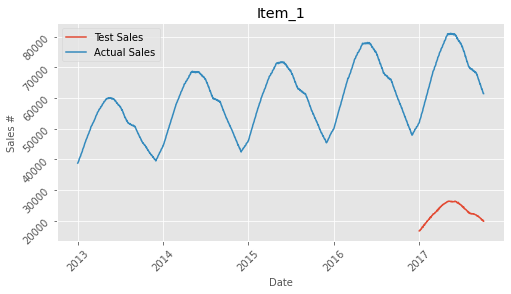

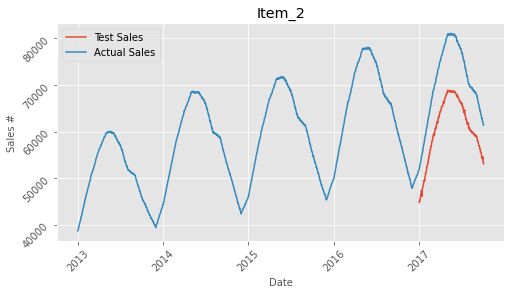

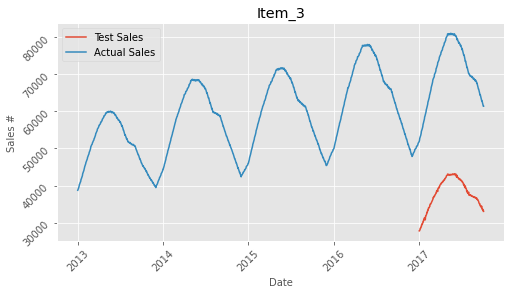

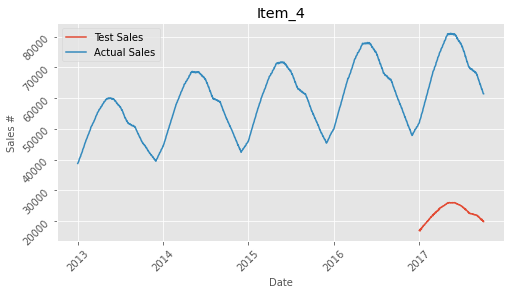

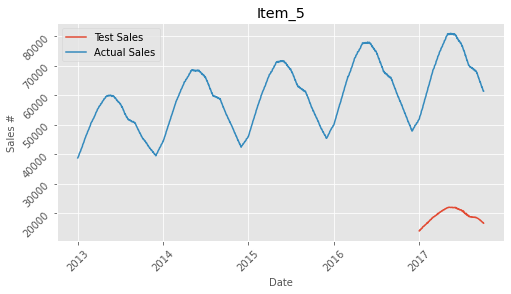

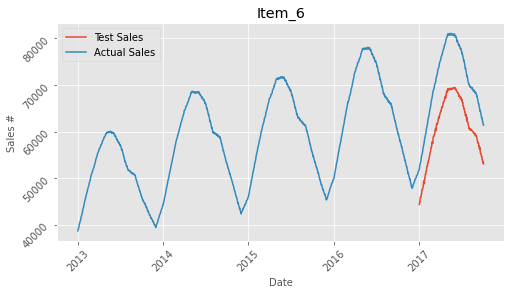

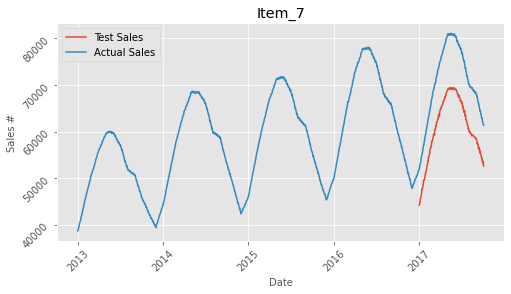

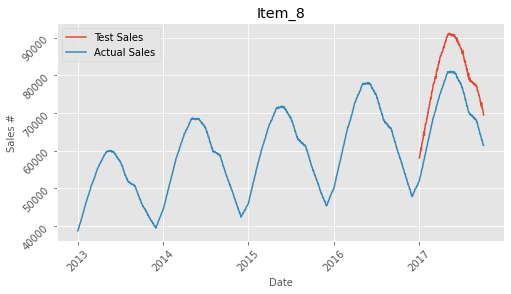

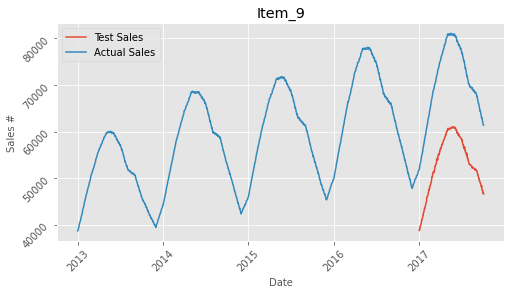

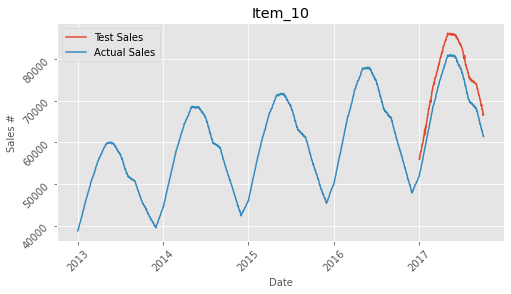

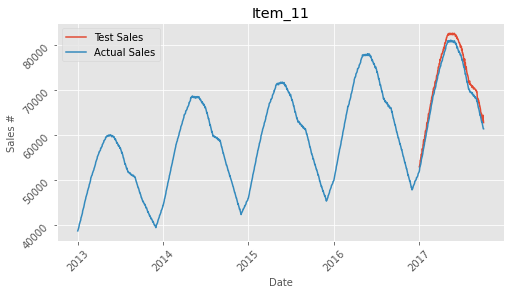

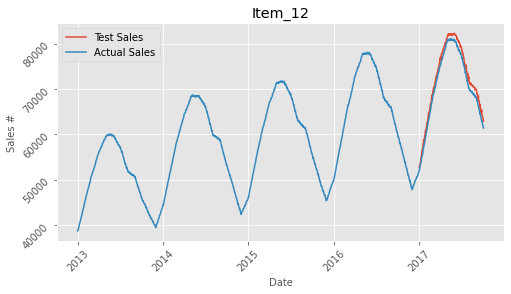

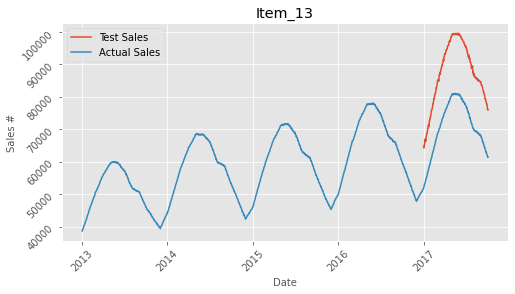

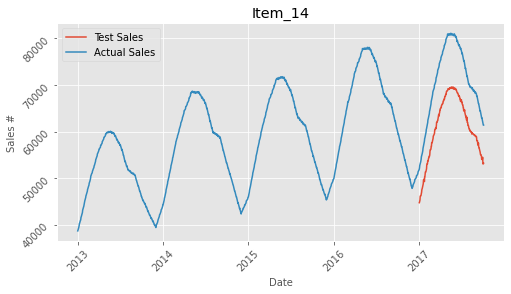

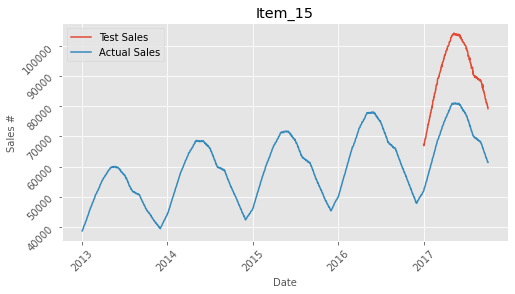

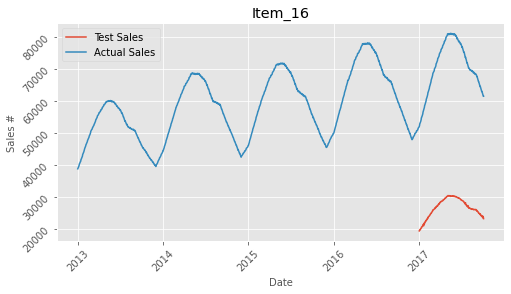

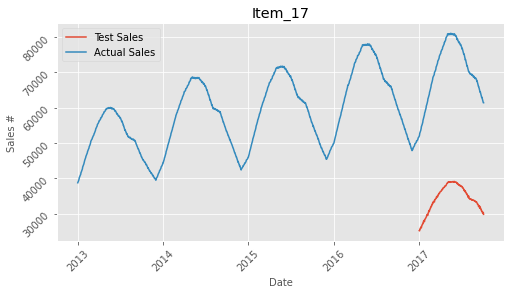

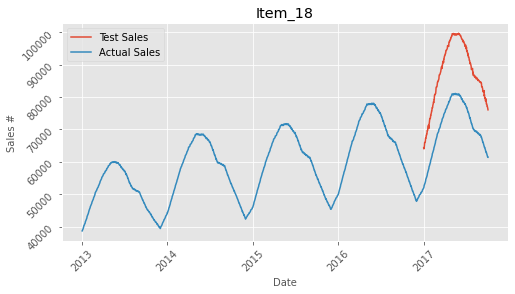

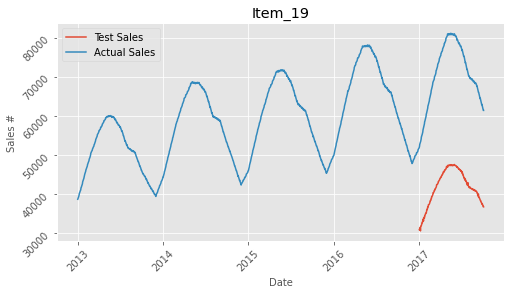

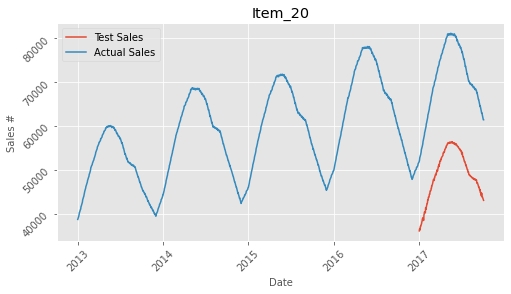

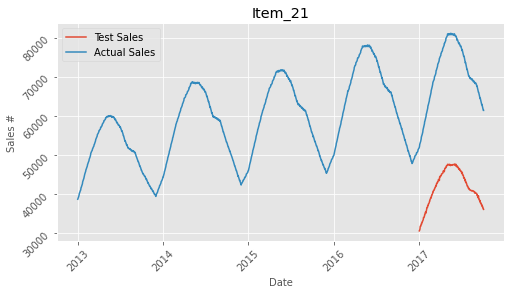

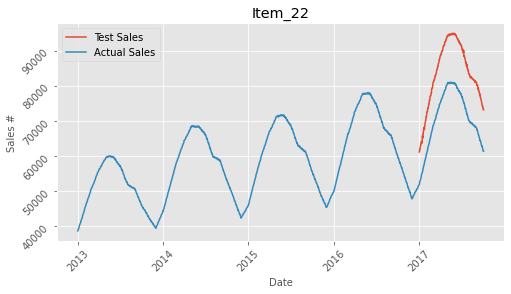

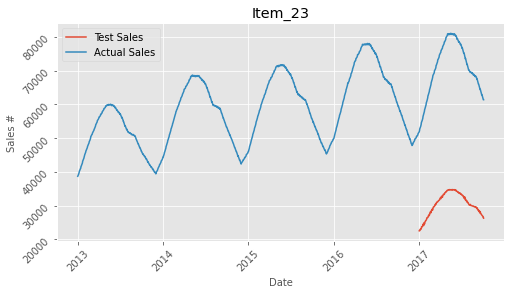

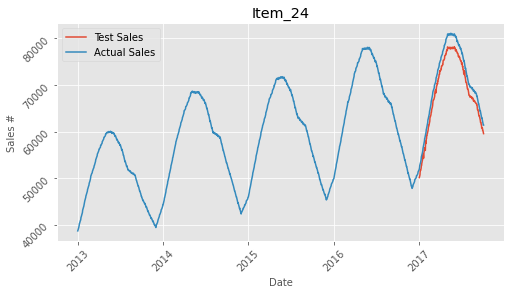

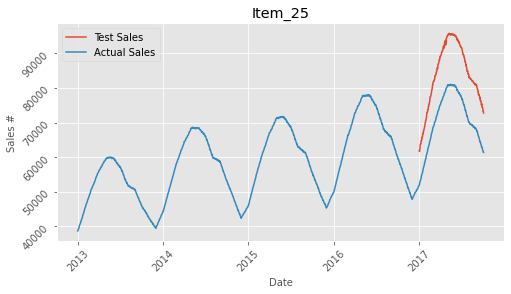

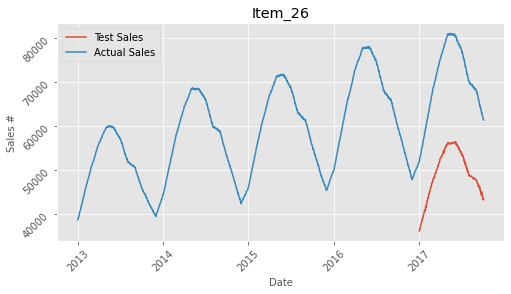

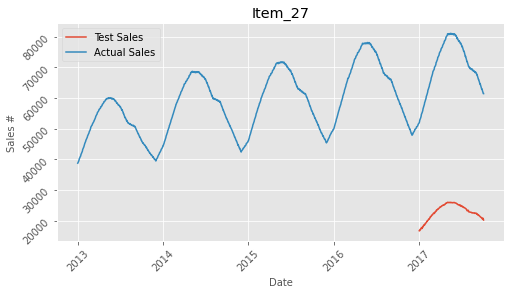

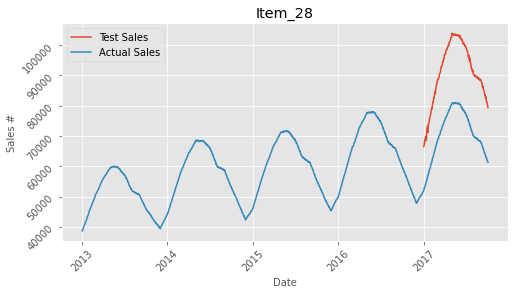

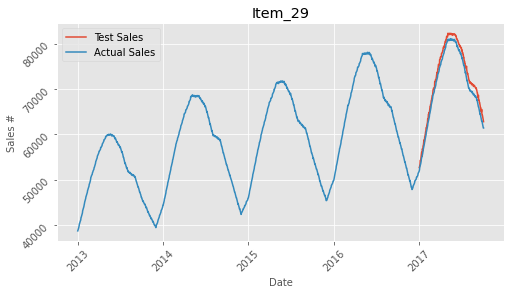

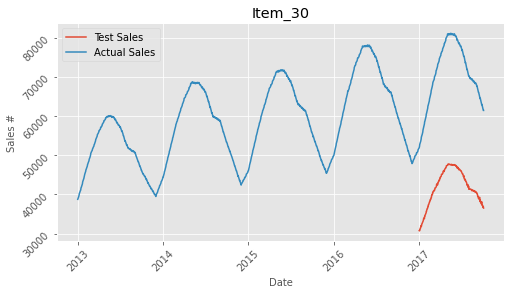

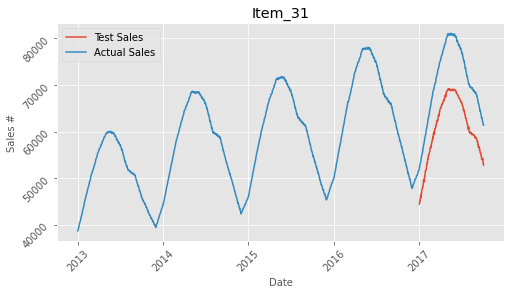

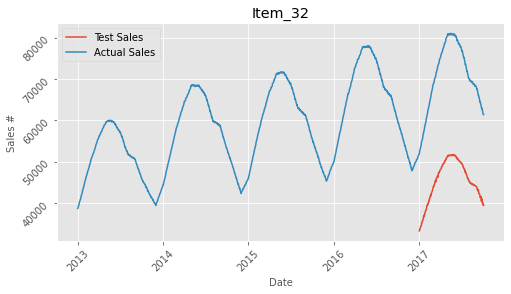

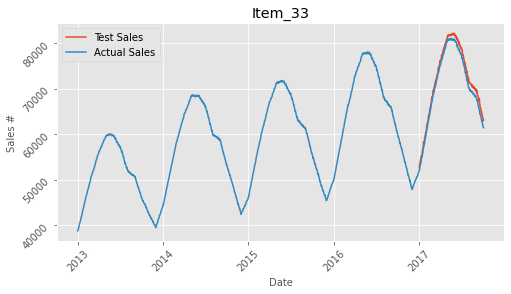

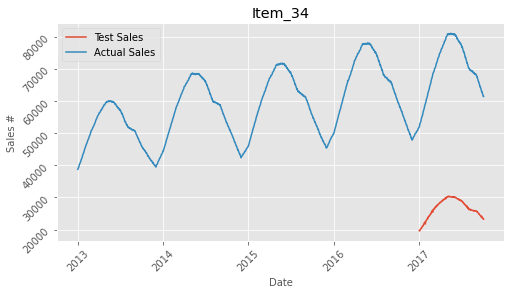

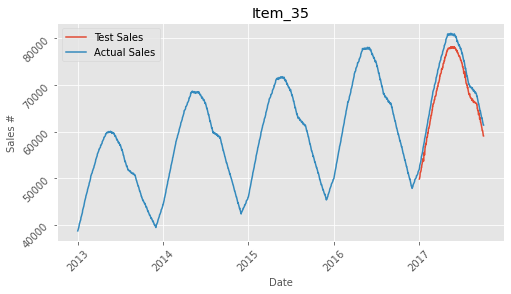

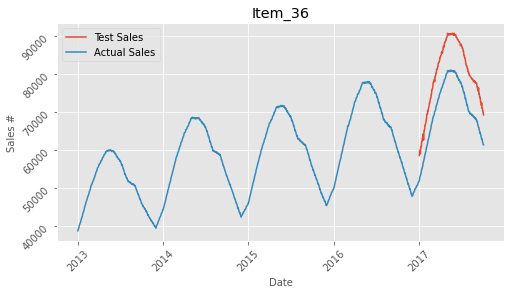

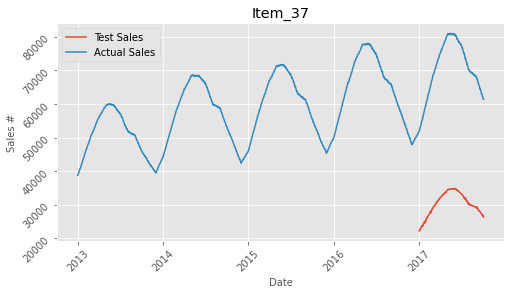

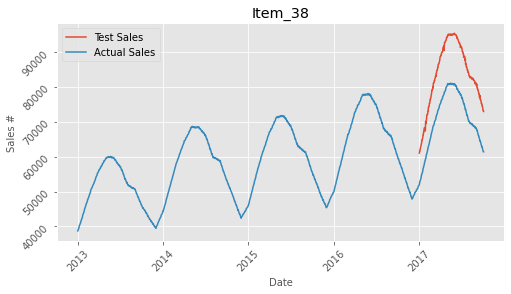

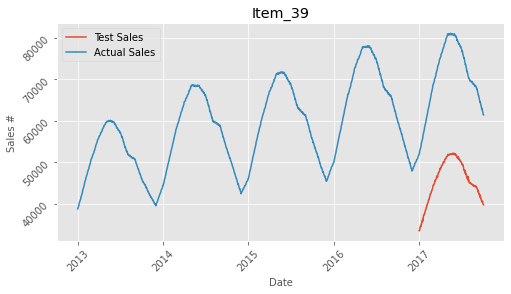

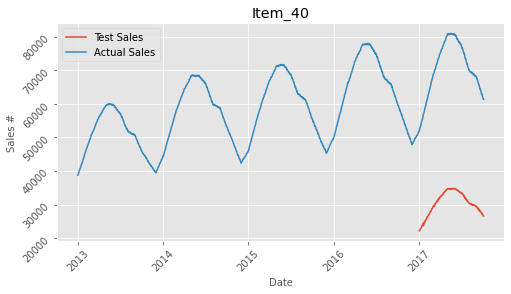

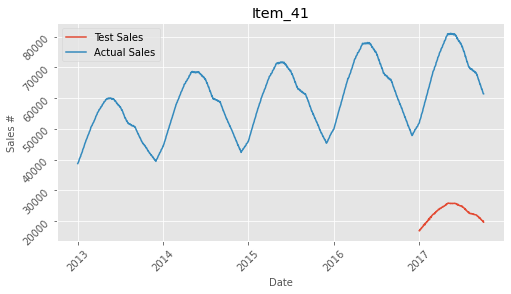

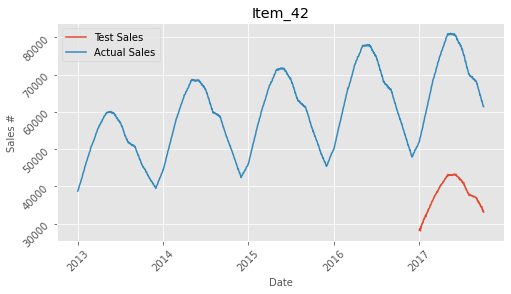

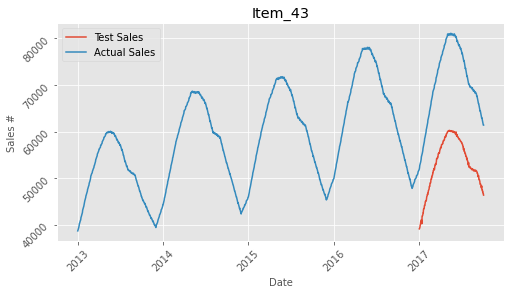

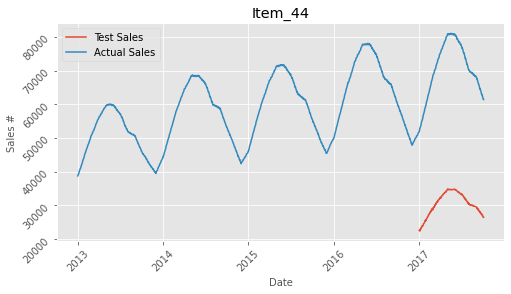

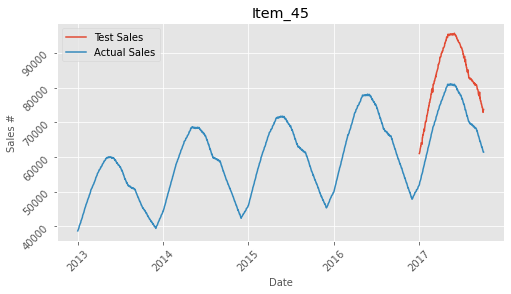

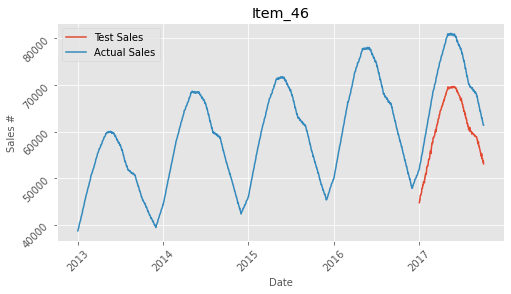

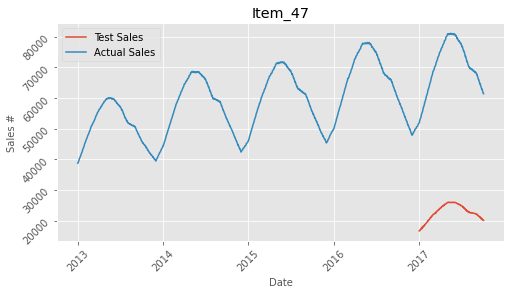

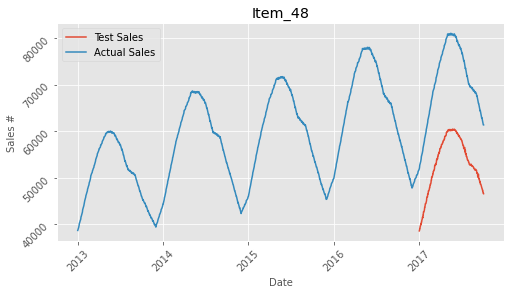

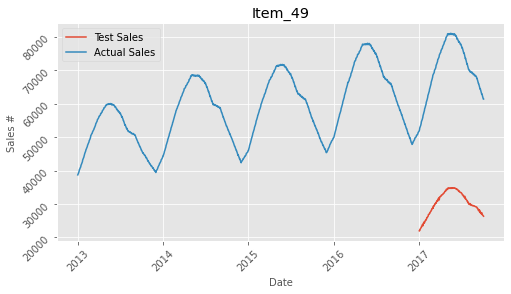

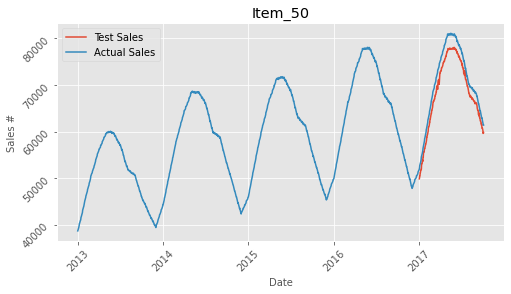

In [ ]:
for k,v in test_forecast_dict_dt.items():
  plotdf_dt = pd.DataFrame(v, index=pd.date_range(start='2017-01-01', end='2017-10-03'))
  plt.figure(figsize=(8,4))
  plt.title('{}'.format(k))
  plt.plot(plotdf_dt, label='Test Sales')
  plt.plot(split_data_dt.sales, label='Actual Sales')
  plt.xlabel('Date', size=10)
  plt.ylabel('Sales #', size=10)
  plt.xticks(rotation=45)
  plt.yticks(rotation=45)
  plt.legend(loc='best')
  plt.show()

In [ ]:
# creating a dataframe out of dictionary that stored the forecast of the test data

test_forecast_dict_dt_df = pd.DataFrame(test_forecast_dict_dt, index=[pd.date_range(start='2017-01-01', end='2017-10-03')])
test_forecast_dict_dt_df = test_forecast_dict_dt_df.reset_index()

In [ ]:
test_forecast_dict_dt_df = test_forecast_dict_dt_df.set_index("level_0", drop= True)

In [ ]:
df_dt = df_test.copy()
df_dt = df_dt.groupby(['item','date']).agg({'sales':'sum'}).reset_index().set_index('date', drop=True)
df_dt = df_dt.groupby('item').sales.rolling(90).sum().shift(-89).dropna().reset_index()
df_dt = pd.pivot_table(data=df_dt, values='sales', columns='item', index='date', aggfunc='sum')
df_dt.index.name=None
df_dt.columns.name=None
df_dt_columns_names = ['Item_'+str(i) for i in df_dt.columns]
df_dt.columns = df_dt_columns_names
df_dt.head(2)

Item_1   Item_2   Item_3   Item_4   Item_5   Item_6   Item_7  \
2013-01-01  12847.0  34650.0  21420.0  12884.0  10630.0  34251.0  34349.0   
2013-01-02  12848.0  34724.0  21472.0  12940.0  10678.0  34380.0  34470.0   

             Item_8   Item_9  Item_10  ...  Item_41  Item_42  Item_43  \
2013-01-01  45188.0  30415.0  42829.0  ...  12902.0  21400.0  30150.0   
2013-01-02  45320.0  30547.0  42939.0  ...  12960.0  21459.0  30282.0   

            Item_44  Item_45  Item_46  Item_47  Item_48  Item_49  Item_50  
2013-01-01  17243.0  47070.0  34620.0  12965.0  30037.0  17099.0  38720.0  
2013-01-02  17293.0  47231.0  34700.0  13015.0  30109.0  17164.0  38874.0  

[2 rows x 50 columns]

In [ ]:
results_dt = (test_forecast_dict_dt_df - df_dt.loc['2017-01-01':'2017-10-03']).dropna()
results_dt.index.name=None

def orlossdt(x):
  if x > 0:
    x = x*10
    return x
  else:
    x = x*3
    return x

for i in results_dt.columns:
  results_dt[i] = results_dt[i].apply(lambda x: orlossdt(x))

results_dt

Item_1  Item_2  Item_3  Item_4  Item_5  Item_6  Item_7  Item_8  \
2017-01-01 -2007.0 -2739.0 -3438.0  -369.0 -2304.0 -5271.0 -5238.0 -7659.0   
2017-01-02 -2274.0 -3933.0 -3732.0  -354.0 -2379.0 -5727.0 -5556.0 -8178.0   
2017-01-03 -2448.0 -3876.0 -4101.0  -276.0 -2220.0 -5826.0 -5310.0 -9192.0   
2017-01-04 -2472.0 -4332.0 -4125.0  -456.0 -2379.0 -6216.0 -5718.0 -8562.0   
2017-01-05 -1824.0 -3834.0 -3498.0 -1926.0 -1998.0 -4257.0 -4449.0 -7554.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2017-09-29 -1557.0 -4146.0 -4761.0 -2307.0 -2037.0 -4359.0 -5724.0 -7902.0   
2017-09-30 -2067.0 -1947.0 -4386.0 -2589.0 -2025.0 -5649.0 -6321.0 -7776.0   
2017-10-01 -2442.0 -4662.0 -4752.0 -2226.0 -2052.0 -4929.0 -4800.0 -7695.0   
2017-10-02 -2451.0 -3936.0 -3996.0 -1728.0 -2550.0 -3642.0 -5871.0 -7752.0   
2017-10-03 -2547.0 -5424.0 -5070.0 -2490.0 -2478.0 -5148.0 -7278.0 -9879.0   

            Item_9  Item_10  ...  Item_41  Item_42  Item_43  Item_44  Item_45  \
2017-01-01 -6894.0  -6315.0  ...  -1254.0  -2247.0  -4566.0  -1413.0  -8217.0   
2017-01-02 -7806.0  -7668.0  ...  -1587.0  -2202.0  -5025.0  -1368.0  -8565.0   
2017-01-03 -7644.0  -7329.0  ...  -1302.0  -2352.0  -5733.0  -2037.0  -9588.0   
2017-01-04 -8034.0  -7959.0  ...  -1464.0  -2307.0  -5580.0  -2964.0  -9324.0   
2017-01-05 -6942.0  -6645.0  ...   -903.0  -2673.0  -4812.0  -1821.0  -8265.0   
...            ...      ...  ...      ...      ...      ...      ...      ...   
2017-09-29 -2982.0  -6813.0  ...  -1854.0  -3450.0  -6081.0  -3936.0  -7872.0   
2017-09-30 -2760.0  -6726.0  ...  -2058.0  -3120.0  -5403.0  -3570.0  -9213.0   
2017-10-01 -3432.0  -8226.0  ...  -2133.0  -3483.0  -5862.0  -4050.0  -8781.0   
2017-10-02 -2496.0  -6582.0  ...  -1203.0  -2658.0  -5262.0  -3867.0  -5523.0   
2017-10-03 -3870.0  -6756.0  ...  -2391.0  -3879.0  -6351.0  -3999.0  -5820.0   

            Item_46  Item_47  Item_48  Item_49  Item_50  
2017-01-01  -3597.0  -2079.0  -6219.0  -4176.0  -6246.0  
2017-01-02  -3939.0  -2370.0  -6507.0  -4326.0  -6519.0  
2017-01-03  -3804.0  -2736.0  -6651.0  -4410.0  -6507.0  
2017-01-04  -4206.0  -2595.0  -7062.0  -4641.0  -7056.0  
2017-01-05  -2160.0  -2028.0  -6249.0  -4152.0  -5784.0  
...             ...      ...      ...      ...      ...  
2017-09-29  -6048.0  -1599.0  -5688.0  -2646.0  -5124.0  
2017-09-30  -5895.0  -1725.0  -5001.0  -2634.0  -5007.0  
2017-10-01  -6507.0  -1983.0  -5772.0  -2730.0  -6204.0  
2017-10-02  -5190.0  -1623.0  -5436.0  -2478.0  -4767.0  
2017-10-03  -7428.0  -1755.0  -6093.0  -2733.0  -4776.0  

[276 rows x 50 columns]

### Model 3

*   ### ARIMA



In [ ]:
### Future Prediction

In [ ]:
ar = df_test.copy()
ar.head()

item  sales
date                   
2013-01-01     1     13
2013-01-02     1     11
2013-01-03     1     14
2013-01-04     1     13
2013-01-05     1     10

In [ ]:
ar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   item    913000 non-null  int64
 1   sales   913000 non-null  int64
dtypes: int64(2)
memory usage: 20.9 MB


In [ ]:
ar.describe()

item          sales
count  913000.000000  913000.000000
mean       25.500000      52.250287
std        14.430878      28.801144
min         1.000000       0.000000
25%        13.000000      30.000000
50%        25.500000      47.000000
75%        38.000000      70.000000
max        50.000000     231.000000

In [ ]:
ar.item.nunique()

50

In [ ]:
# every date has 500 entries i.e. 10 products across 50 stores
# there are about 1826 date values i.e. 5 years of data

ar.index.value_counts()

2013-01-01    500
2016-05-11    500
2016-05-09    500
2016-05-08    500
2016-05-07    500
             ... 
2014-08-29    500
2014-08-28    500
2014-08-27    500
2014-08-26    500
2017-12-31    500
Name: date, Length: 1826, dtype: int64

In [ ]:
ar = ar[ar['item']==1]
ar = ar.drop(['item'], axis=1)

#### Observations


*   Due to the complexity in arriving at the the p,d,q values from the acf and pacf plots and the time involved in computing the same through iterations for all 50 items, we are performing ARIMA & SARIMA by taking out a single item for practice purposes



In [ ]:
# resampling the data by the starting of each month
ar = ar.resample('MS').sum().reset_index()
ar = ar.set_index('date', drop=True)

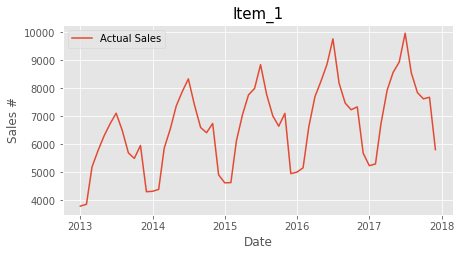

In [ ]:
plt.figure(figsize=(7,3.5))
plt.title('Item_1', size=15)
plt.xlabel('Date', size=12)
plt.ylabel('Sales #', size=12)
plt.plot(ar, label='Actual Sales')
plt.legend()

plt.show()

#### EDA - Decomposing

<Figure size 432x288 with 0 Axes>

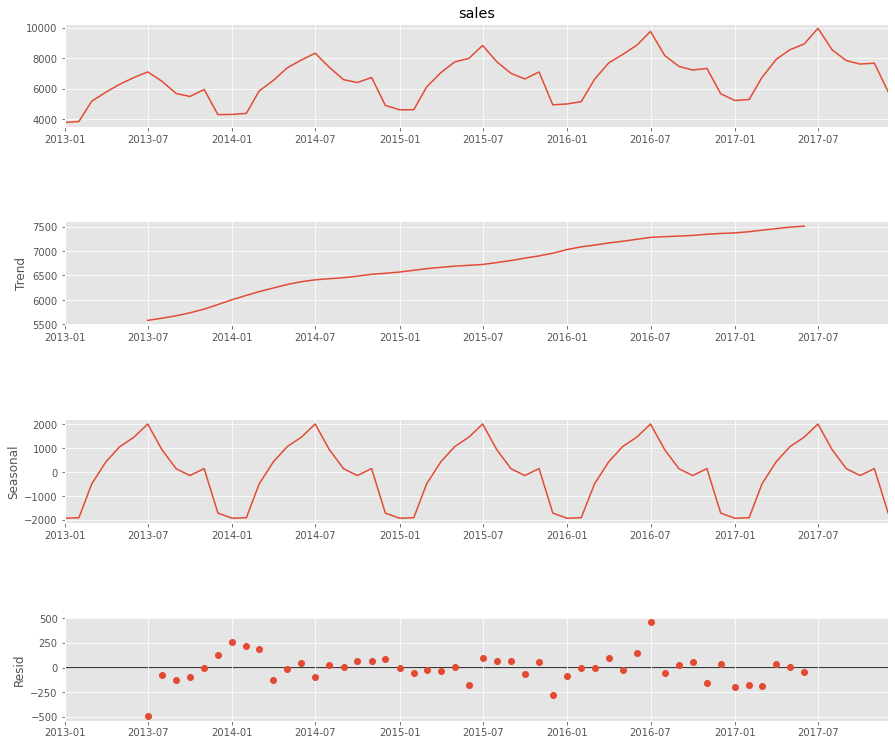

In [ ]:
result = sm.tsa.seasonal_decompose(ar['sales'], model='additive') #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

### Rolling Stats

*   Check for Stationarity



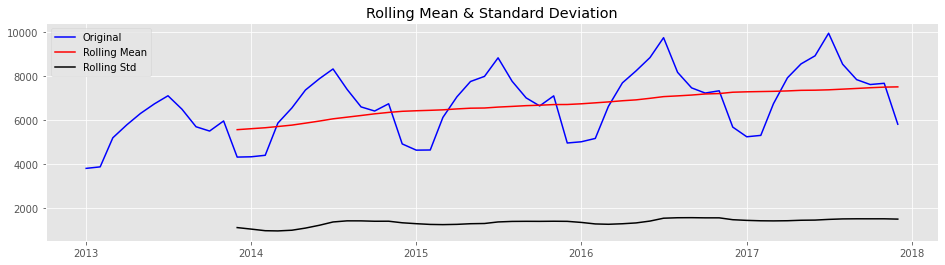

In [ ]:
def roll_stats(timeseries, window = 12, cutoff = 0.01):
    
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
   # plt.rcParams['agg.path.chunksize'] = 50000
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
roll_stats(ar['sales']) 

#### Augmented Dickey Fuller Test

In [ ]:
test = adfuller(ar.sales)
output = pd.Series(test[0:4], index=['ADF stat', 'p_value', 'Lags', 'Obs'])

for key,value in test[4].items():
  output['Critical value {}'.format(key)]=value
print(output,'\n')

if output[1] < 0.05:
  print('The data is stationary')
else:
  print('The data is non-stationary.')

ADF stat              -4.926312
p_value                0.000031
Lags                  11.000000
Obs                   48.000000
Critical value 1%     -3.574589
Critical value 5%     -2.923954
Critical value 10%    -2.600039
dtype: float64 

The data is stationary


### Train Test Split

In [ ]:
ar.index.name=None
train_ar = ar.loc[:'2016-12-31']
test_ar = ar.loc['2017-01-01':]

print(len(ar))
print(len(train_ar))
print(len(test_ar))

60
48
12


In [ ]:
# defining a range for p, d, q

p = range(0,9)
d = range(0,9)
q = range(0,9)

# creating a list of different combinations of p,d,q
pdq_combination = list(itertools.product(p,d,q))

# creating a list for rmse and order of p,d,q
rmse = []
order = []

for pdq in pdq_combination:
  try:
    model = ARIMA(train_ar, order=pdq).fit()
    prediction = model.predict(start = len(train_ar), end = len(ar)-1)
    rmse_err = np.sqrt(metrics.mean_squared_error(test_ar, prediction))
    r2_err = metrics.r2_score(test_ar, prediction)
    rmse.append(rmse_err)
    order.append(pdq)
    r2.append(r2_err)
  except:
    continue

results = pd.DataFrame(index = order, columns=['RMSE'], data=rmse)
results.index.name='p d q'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

In [ ]:
results_final = pd.DataFrame(results.RMSE.sort_values(ascending=True))
results_final.head()

RMSE
p d q                 
(8, 0, 0)  1060.754194
(2, 0, 3)  1200.278879
(7, 0, 0)  1447.428257
(6, 0, 0)  1610.152930
(0, 0, 8)  1621.855509

#### Observations

*   Here we are taking the hyperparameter value which has the least RMSE value



In [ ]:
# we choose the p,d,q values with the least RMSE value
model = ARIMA(train_ar, order=(8,0,0)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

In [ ]:
prediction_test = model.predict(start=len(train_ar), end = len(ar)-1)
prediction_test.head()

2017-01-01    5586.712292
2017-02-01    6002.481386
2017-03-01    6967.279290
2017-04-01    6803.189474
2017-05-01    7288.813256
Freq: MS, dtype: float64

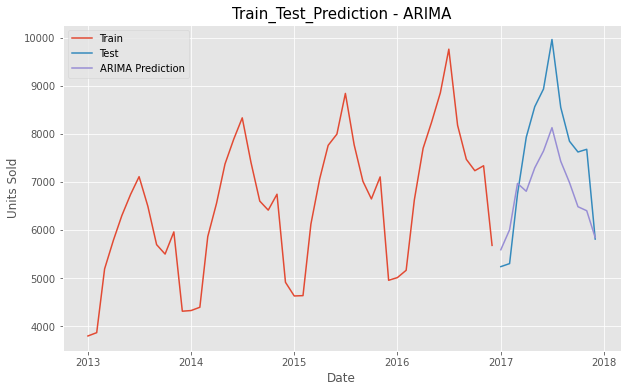

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_ar,label='Train')
plt.plot(test_ar, label='Test')
plt.plot(prediction_test, label='ARIMA Prediction')
plt.xlabel('Date', size=12)
plt.ylabel('Units Sold', size=12)
plt.title('Train_Test_Prediction - ARIMA', size=15)
plt.legend()
plt.show()

###  Future Forecast

In [ ]:
final_model_arima = ARIMA(ar, order=(8,0,0)).fit()
pred_future_arima = final_model_arima.predict(start=len(ar), end=len(ar)+2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
# predicted values of the future without factoring in the Seasonality
pred_future_arima

2018-01-01    5725.884366
2018-02-01    6075.905465
2018-03-01    7007.648155
Freq: MS, dtype: float64

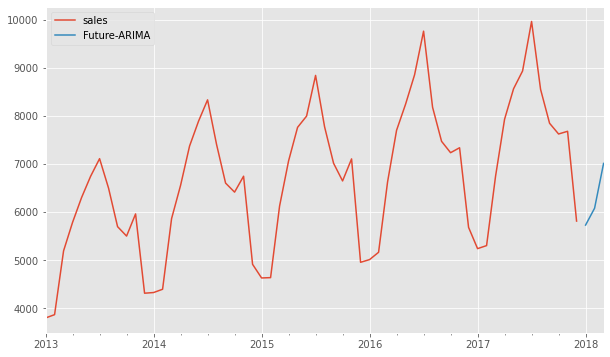

In [ ]:
ar.plot(legend=True, label='Actual Sales', figsize=(10,6))
pred_future_arima.plot(legend=True, label='Future-ARIMA', figsize=(10,6))
plt.legend(loc='best')
plt.show()

In [ ]:
mse_ar = metrics.mean_squared_error(test_ar, prediction_test)
rmse_ar = np.sqrt(metrics.mean_squared_error(test_ar, prediction_test))
mae_ar = metrics.mean_absolute_error(test_ar, prediction_test)
mape_ar = metrics.mean_absolute_percentage_error(test_ar, prediction_test)
r2_ar = metrics.r2_score(test_ar,prediction_test)

### Model 4

### SARIMA

In [ ]:
# defining seasonal order by trial and error. Started with 12 

sarima_model = SARIMAX(ar, order=(8,0,0), seasonal_order=(8,0,0,12)).fit()
predict_seasonal_test = sarima_model.predict(start=len(train_ar), end=len(ar)-1)
predict_seasonal_future = sarima_model.predict(start=len(ar), end=len(ar)+2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelih

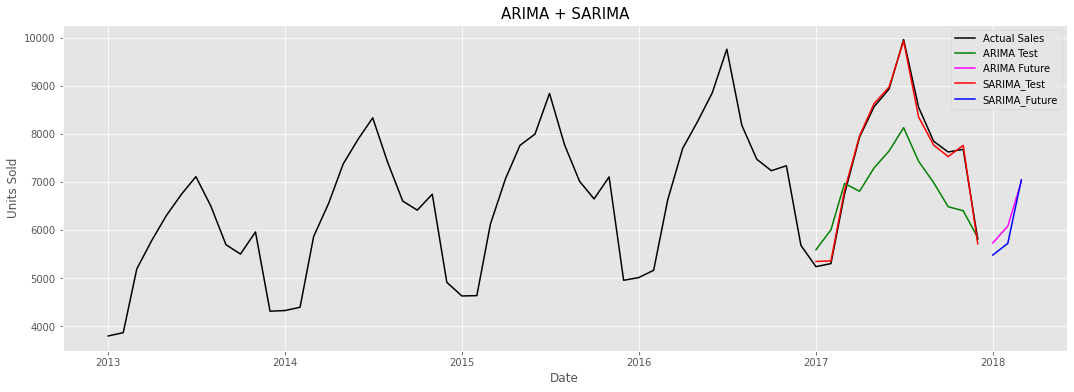

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(18,6))
plt.plot(ar, label='Actual Sales', color='black')
plt.plot(prediction_test, label='ARIMA Test', color='green')
plt.plot(pred_future_arima, label='ARIMA Future', color='magenta')
plt.plot(predict_seasonal_test, label='SARIMA_Test', color='red')
plt.plot(predict_seasonal_future, label='SARIMA_Future', color='blue')
plt.title('ARIMA + SARIMA', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend(loc='best')
plt.show()

#### observation


*   The SARIMA model performing well than the ARIMA model 



In [ ]:
r2_sar = metrics.r2_score(test_ar, predict_seasonal_test)
rmse_sar = np.sqrt(metrics.mean_squared_error(test_ar, predict_seasonal_test))

In [ ]:
results_dict = {'R2': [r2_ar, r2_sar, r2_dt, r2_xgb], 'RMSE':[rmse_ar, rmse_sar, rmse_dt, rmse_xgb]}
results_dict = pd.DataFrame(results_dict, index=['ARIMA','SARIMA','DecisionTree','XG Boost'])
results_dict = results_dict.sort_values(by=['R2','RMSE'], ascending=[False, True])

In [ ]:
# Rounding off results

def rounding(x):
  a = round(x,2)
  return a
for i in results_dict.columns:
  results_dict[i] = results_dict[i].apply(lambda x: rounding(x))

In [ ]:
results_dict

R2     RMSE
SARIMA        1.00    91.27
DecisionTree  0.90  2498.92
XG Boost      0.89  2563.82
ARIMA         0.44  1060.75

#### observation 

*   The Time series model SARIMA performed well and given the R2 score of 1 with the least RMSE error of 91.27
